In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from tqdm import tqdm

from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier


from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, r_regression, f_regression, mutual_info_regression, RFECV


from tpot import TPOTRegressor

from textwrap import wrap

from main.components.scaler import Scaler
from main.components.imputer import Imputer
from main.components.one_hot_encoder import CustomOneHotEncoder
from main.constants import CATEGORICAL_ATTRIBUTES, CONTINUOUS_ATTRIBUTES, IGF, PROLACTIN, VITAMINE_D, PCO, inflammatory_attributes, igf_associated_features
from main.components.preprocessing_methods import remove_outliers, get_continuous_attributes_except, explore_all_variations_of_preprocessing
from main.components.hyperparameter_tuning_methods import hyperparameter_tuning_general, hyperparameter_tuning_linear, compare_random_states, train_model
from main.components.feature_importance_methods import get_feature_importance_lasso, get_feature_importance_tree, get_feature_importance_rf, rename_importnace_col, merge_feature_importances, rank_importances, feature_selection_mutual_info_regression, recursive_feature_elimination, get_permutation_importance



import nest_asyncio
nest_asyncio.apply()

pd.set_option('display.max_columns', None) # enable showing all columns of the df
pd.set_option('display.max_rows', None)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)


In [2]:
dataset_file_path = 'data/preprocessed_dataset.csv'
raw_df = pd.read_csv(dataset_file_path)
raw_df.sample(5)

PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro  IGF-1 ng/ml (N: 100-311)  proBNP  AMH (ng/ml) *7,14=pmol/l  weight  height (cm)        BMI  systolic BP (ciśnienie skurczowe)  diastolic BP (ciśnienie rozskurczowe)  Hypertension  Waist Circumference (WC)  WC>88  Hip Circumference (HC)  WHR (Waist/Hip ratio)  WHR>0,85 (WHO)  WHR>0,8 (NIDDK)  WHTR (Waist/Height Ratio)  WHTR>0,5  overweight/obesity 0-normal/low, 1-overweight, 2-obesity  irregular cycles (0-nie, 1-tak)  ovulation (0-brak, 1-obecna)  PCO ovary morfology in USG (0-brak, 1--obecna)  stromal hypertrophy in ovary (0-brak, 1-obecny)  acne  hirsutism  FG score (Ferriman-Gallway score - stopień androgenizacji)  hyperandrogenism  hypothyroidism  Volume of the thyroid  Right Lobe  Volume of the thyroid  Left Lobe  thyroid volume  nodules 0-lack, 1-RL,  2-LL, 3-both  chronic thyroiditis  Vole of the Right Ovary  Volume of the  Left Ovary  ovaries volume - total  follicules >12  WBC x10^3/ul  neutrophil x10^3/ul  \
214                                                         0                       NaN     NaN                       NaN    53.5        170.0  18.512111                                NaN                                    NaN           NaN                      72.0    0.0                    77.0               0.935065             1.0              1.0                   0.423529       0.0                                                       0.0                              0.0                           NaN                                             NaN                                              NaN   0.0        0.0                                                         NaN               NaN             0.0                           5.152000                          3.211000        8.363000                                  0.0                  1.0                      NaN                        NaN                     NaN             NaN          5.01                 2.21   
608                                                         1                     241.0   49.99                       NaN    98.0        162.0  37.341869                              113.0                                   97.0           0.0                     105.0    1.0                   104.0               1.009615             1.0              1.0                   0.648148       1.0                                                       2.0                              1.0                           0.0                                             1.0                                              1.0   0.0        0.0                                                         6.0               1.0             1.0                           7.896000                          4.480000       12.376000                                  0.0                  1.0                    13.90                      14.89                   28.79             1.0          8.32                 5.13   
984                                                         4                     252.0     NaN                       NaN    71.0        154.0  29.937595                              122.0                                   90.0           0.0                       NaN    NaN                     NaN                    NaN             NaN              NaN                        NaN       NaN                                                       1.0                              1.0                           1.0                                             NaN                                              1.0   NaN        1.0                                                         NaN               1.0             1.0                           5.492214                          4.448952        9.941166                                  NaN                  NaN                    12.68                        NaN                     NaN             1.0          7.75                  NaN   
588                          

Left only the values within the interval: [-11.26, 499.68]
Removed 8 outlier values of IGF-1 ng/ml (N: 100-311) -> 1.26 % of all the not null examples


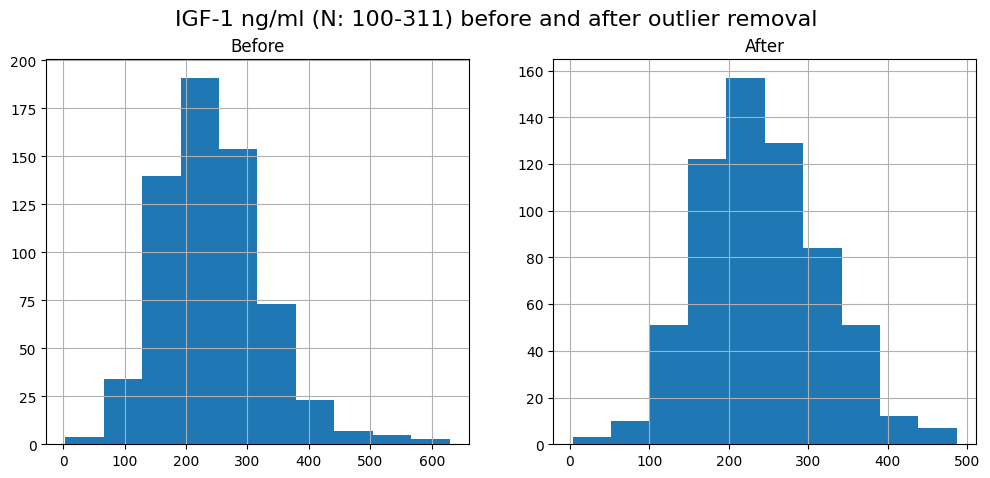

In [3]:
df = remove_outliers(raw_df, IGF)

In [4]:
df_igf_cleaned = df.dropna(subset=[IGF])

X_igf, y_igf = df_igf_cleaned.drop(columns=[IGF]), df_igf_cleaned[IGF]
X_train_igf, X_test_igf, y_train_igf, y_test_igf = train_test_split(X_igf, y_igf, test_size=0.2, random_state=42)

In [5]:
continuous_preprocessor = Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))])
tree_continuous_preprocessor = Pipeline([('imputer', KNNImputer(n_neighbors=9))])

# categorical_preprocessor = Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])
categorical_preprocessor = Pipeline([('imputer', IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=10, n_jobs=-1), max_iter=40, initial_strategy='most_frequent')), ('one_hot_encoder', OneHotEncoder(handle_unknown='error', drop='if_binary'))])


## Models exploration

In [5]:
# models = [
#         DecisionTreeRegressor(max_depth=7, random_state=42),
#         Lasso(),
#         Ridge(),
#         RandomForestRegressor(),
#         ]

# #  TODO: maybe add DropHighMissingColumns

# continuous_preprocessings = {
#     'PT_iterative_basic': Pipeline([('scaler', PowerTransformer()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
#     'PT_KNN': Pipeline([('scaler', PowerTransformer()), ('imputer', KNNImputer(n_neighbors=9))]),
#     'RS_iterative_basic': Pipeline([('scaler', RobustScaler()), ('imputer', IterativeImputer(initial_strategy='median', max_iter=10, tol=0.01))]),
#     'RS_KNN': Pipeline([('scaler', RobustScaler()), ('imputer', KNNImputer(n_neighbors=9))]),
# }

# categorical_preprocessings = {
#     # 'custom_ohe_no_imputing': Pipeline([('one_hot_encoder', CustomOneHotEncoder(columns_for_one_hot_encoding, new_column_names_map, advanced_encoding=True))]),
#     'original_ohe_no_imputing': Pipeline([('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
#     'original_ohe_+_impute_knn': Pipeline([('imputer', KNNImputer(n_neighbors=1)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
#     'original_ohe_+_impute_rf': Pipeline([('imputer', IterativeImputer(estimator=RandomForestClassifier(), initial_strategy='most_frequent', max_iter=10, random_state=0)), ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))]),
# }


# scores_df = explore_all_variations_of_preprocessing(X_train_igf, y_train_igf, IGF, models, continuous_preprocessings, categorical_preprocessings)

## Hyperparameter tuning

### Lasso

Fitting 15 folds for each of 7 candidates, totalling 105 fits


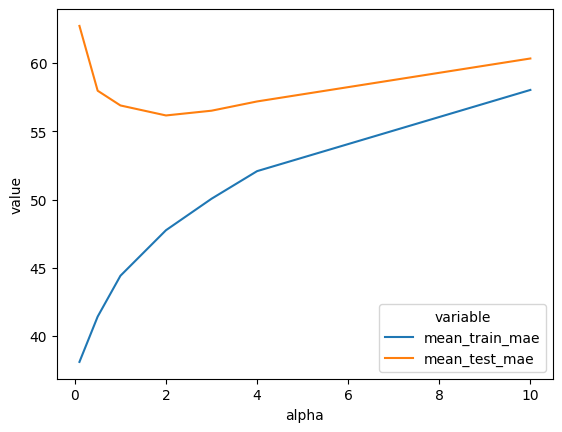

alpha  mean_train_mae  mean_test_mae
0   0.1       38.103286      62.724174
1   0.5       41.424363      57.976270
2     1       44.417298      56.895861
3     2       47.754762      56.163828
4     3       50.060852      56.512038
5     4       52.083143      57.190029
6    10       58.033392      60.337918

In [17]:
param_grid_lasso = {
    'model__alpha': [0.1, 0.5, 1, 2, 3, 4, 10],
}

lasso_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_igf, y_train_igf, IGF, Lasso(), continuous_preprocessor, categorical_preprocessor, param_grid_lasso, main_parameter='alpha')
lasso_model_hyperparam_tuning_df

Chosen alpha: 1

### Ridge

Fitting 15 folds for each of 8 candidates, totalling 120 fits


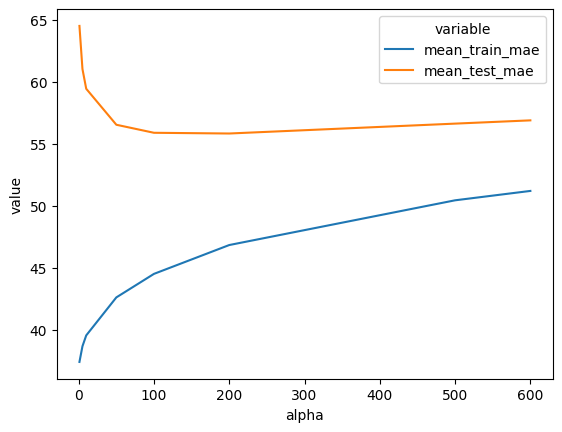

alpha  mean_train_mae  mean_test_mae
0     1       37.413374      64.500115
1     5       38.677579      61.023545
2    10       39.550875      59.433555
3    50       42.614708      56.533328
4   100       44.511782      55.885112
5   200       46.836179      55.827248
6   500       50.442018      56.624161
7   600       51.198200      56.886838

In [19]:
param_grid_ridge = {
    "model__alpha": [1, 5, 10, 50, 100, 200, 500, 600],
}

vit_d_ridge_model_hyperparam_tuning_df = hyperparameter_tuning_linear(X_train_igf, y_train_igf, IGF, Ridge(), continuous_preprocessor, categorical_preprocessor, param_grid_ridge, main_parameter='alpha')
vit_d_ridge_model_hyperparam_tuning_df

Chosen alpha: 50

### RandomForest

In [30]:
param_grid_rf = {
    'model__n_estimators': [200],
    'model__max_features': ['sqrt'],
    'model__max_depth': [None],
    'model__min_samples_split': [8, 10, 12],
    'model__min_samples_leaf': [3, 5, 7],
}

tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_igf, y_train_igf, IGF, RandomForestRegressor(), continuous_preprocessor, categorical_preprocessor, param_grid_rf)
tree_model_hyperparam_tuning_df.sort_values(by='mean_test_score')

Fitting 15 folds for each of 18 candidates, totalling 270 fits


params  mean_train_mae  mean_test_mae
16  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 10, 'model__n_estimators': 200}       41.810143      60.099159
9    {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 8, 'model__n_estimators': 200}       31.832130      60.177599
1     {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 10, 'model__n_estimators': 200}       33.928776      60.182291
10  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 10, 'model__n_estimators': 200}       33.874325      60.235325
3      {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 8, 'model__n_estimators': 200}       37.041478      60.241482
4     {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}       36.968499      60.250744
6      {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 8, 'model__n_estimators': 200}       41.863576      60.289191
13  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}       36.979434      60.297108
14  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 12, 'model__n_estimators': 200}       38.359807      60.302342
5     {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 12, 'model__n_estimators': 200}       38.378933      60.303784
8     {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 12, 'model__n_estimators': 200}       41.801936      60.310689
11  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 12, 'model__n_estimators': 200}       35.794937      60.318420
12   {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 8, 'model__n_estimators': 200}       37.014351      60.320702
17  {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 12, 'model__n_estimators': 200}       41.834482      60.323171
7     {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 10, 'model__n_estimators': 200}       41.830270      60.325626
0      {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 8, 'model__n_estimators': 200}       31.939967      60.368305
2     {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__min_samples_split': 12, 'model__n_estimators': 200}       35.736612      60.424813
15   {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 7, 'model__min_samples_split': 8, 'model__n_estimators': 200}       41.780765      60.425780

In [11]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=13)

tuned_df = compare_random_states(X_train_igf, y_train_igf, rf_model, IGF, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [09:22<00:00,  5.68s/it]


cv_mae
56 -60.252833
24 -60.319136
71 -60.389253
67 -60.390057
8  -60.415431

### DecisionTreeRegressor

In [10]:
param_grid_tree = {
    "model__criterion": ["squared_error", "absolute_error"],
    "model__max_depth": [5, 7, 10, 15],
    "model__splitter": ["random"],
    "model__min_samples_split": [15, 20, 25, 30],
    "model__min_samples_leaf": [10, 15, 20, 25],
    }

tree_model_hyperparam_tuning_df = hyperparameter_tuning_general(X_train_igf, y_train_igf, IGF, DecisionTreeRegressor(), continuous_preprocessor, categorical_preprocessor, param_grid_tree)
tree_model_hyperparam_tuning_df.sort_values(by='mean_test_score')

Fitting 15 folds for each of 128 candidates, totalling 1920 fits


params  mean_train_mae  mean_test_mae
60    {'model__criterion': 'squared_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}       57.744918      64.820633
12     {'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}       57.560372      64.921653
124  {'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}       56.128836      65.008289
126  {'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 25, 'model__splitter': 'random'}       56.347978      65.039668
70    {'model__criterion': 'absolute_error', 'model__max_depth': 5, 'model__min_samples_leaf': 15, 'model__min_samples_split': 25, 'model__splitter': 'random'}       54.164183      65.175315
105  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 20, 'model__splitter': 'random'}       54.071129      65.201847
14     {'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_leaf': 25, 'model__min_samples_split': 25, 'model__splitter': 'random'}       58.028373      65.317146
106  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 25, 'model__splitter': 'random'}       54.157504      65.367604
63    {'model__criterion': 'squared_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 30, 'model__splitter': 'random'}       57.440324      65.409121
13     {'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_leaf': 25, 'model__min_samples_split': 20, 'model__splitter': 'random'}       58.314826      65.413862
74    {'model__criterion': 'absolute_error', 'model__max_depth': 5, 'model__min_samples_leaf': 20, 'model__min_samples_split': 25, 'model__splitter': 'random'}       56.046721      65.437053
30     {'model__criterion': 'squared_error', 'model__max_depth': 7, 'model__min_samples_leaf': 25, 'model__min_samples_split': 25, 'model__splitter': 'random'}       57.584050      65.561062
68    {'model__criterion': 'absolute_error', 'model__max_depth': 5, 'model__min_samples_leaf': 15, 'model__min_samples_split': 15, 'model__splitter': 'random'}       54.494802      65.620856
84    {'model__criterion': 'absolute_error', 'model__max_depth': 7, 'model__min_samples_leaf': 15, 'model__min_samples_split': 15, 'model__splitter': 'random'}       52.416798      65.641603
109  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 25, 'model__min_samples_split': 20, 'model__splitter': 'random'}       56.098040      65.669238
26     {'model__criterion': 'squared_error', 'model__max_depth': 7, 'model__min_samples_leaf': 20, 'model__min_samples_split': 25, 'model__splitter': 'random'}       55.675487      65.695743
127  {'model__criterion': 'absolute_error', 'model__max_depth': 15, 'model__min_samples_leaf': 25, 'model__min_samples_split': 30, 'model__splitter': 'random'}       56.295925      65.714042
28     {'model__criterion': 'squared_error', 'model__max_depth': 7, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}       57.860779      65.812832
29     {'model__criterion': 'squared_error', 'model__max_depth': 7, 'model__min_samples_leaf': 25, 'model__min_samples_split': 20, 'model__splitter': 'random'}       57.939709      65.842100
44    {'model__criterion': 'squared_error', 'model__max_depth': 10, 'model__min_samples_leaf': 25, 'model__min_samples_split': 15, 'model__splitter': 'random'}       57.160604      65.882672
107  {'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__min_samples_leaf': 20, 'model__min_samples_split': 30, 'model__spl

In [12]:
model = DecisionTreeRegressor(criterion="squared_error", max_depth=15, min_samples_leaf=25, min_samples_split=15, splitter='random')
	
tuned_df = compare_random_states(X_train_igf, y_train_igf, model, IGF, continuous_preprocessor, categorical_preprocessor)
tuned_df.sort_values(by='cv_mae', ascending=False).head(5)

100%|██████████| 99/99 [00:42<00:00,  2.31it/s]


cv_mae
16 -63.625855
45 -63.926099
81 -64.088162
88 -64.180902
73 -64.462722

## Best models - IGF

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


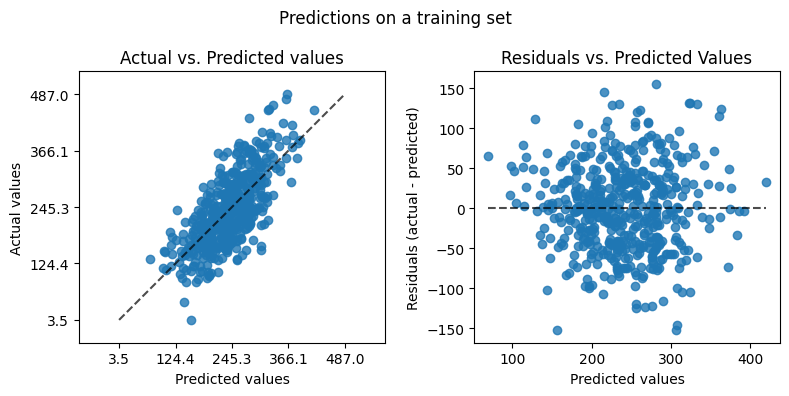

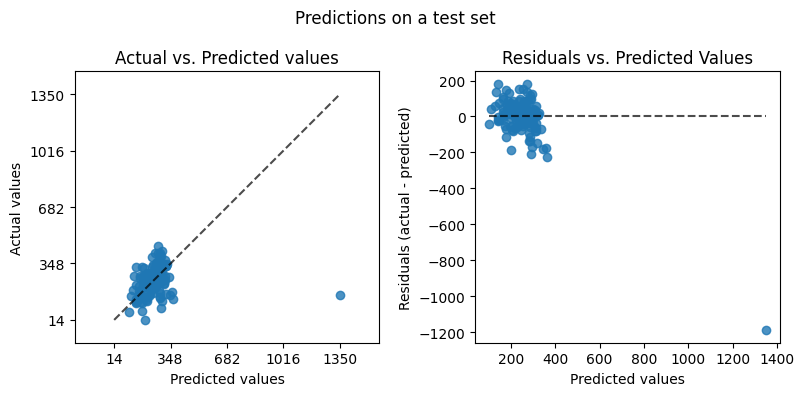

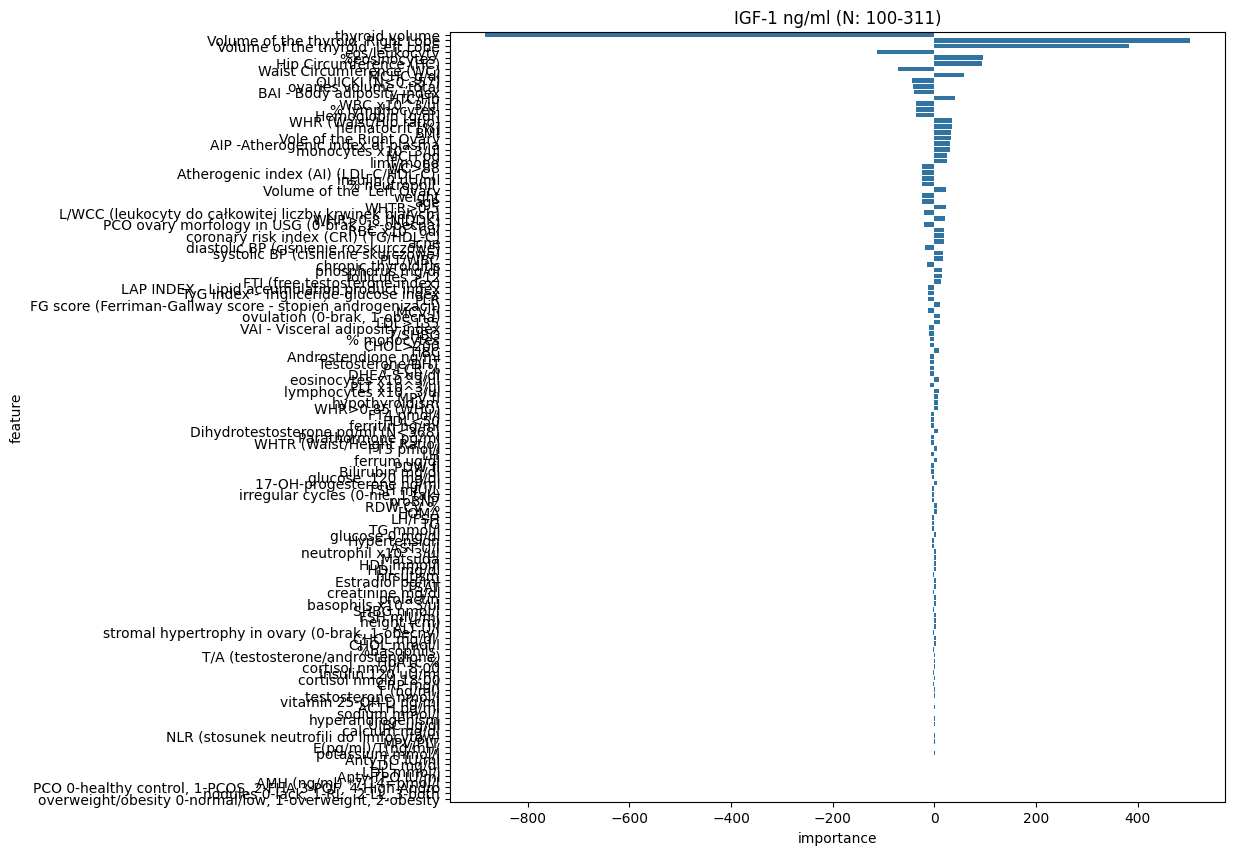

model  data_set        mse     mae     rmse     r2
0  LinearRegression()  training   2864.264  42.746   53.519  0.516
1  LinearRegression()      test  17644.244  70.916  132.832 -1.607

In [7]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr = train_model(lr_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


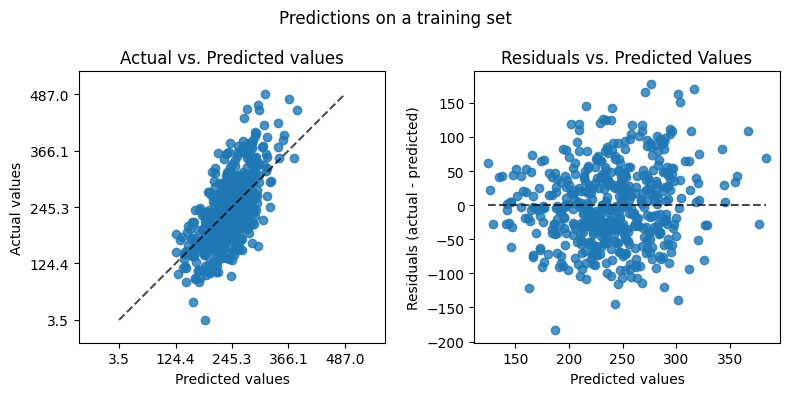

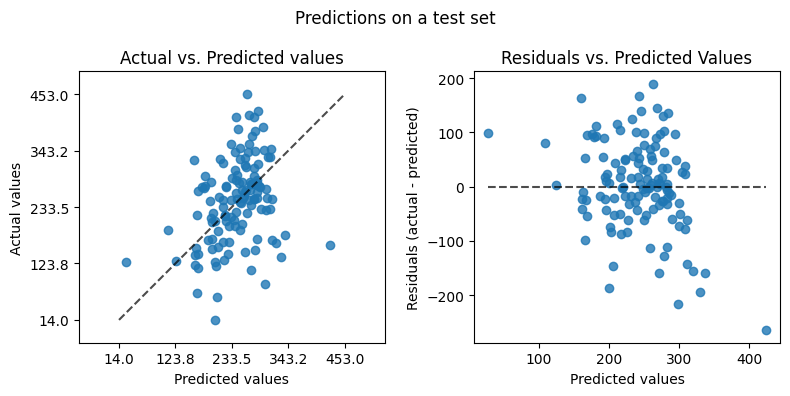

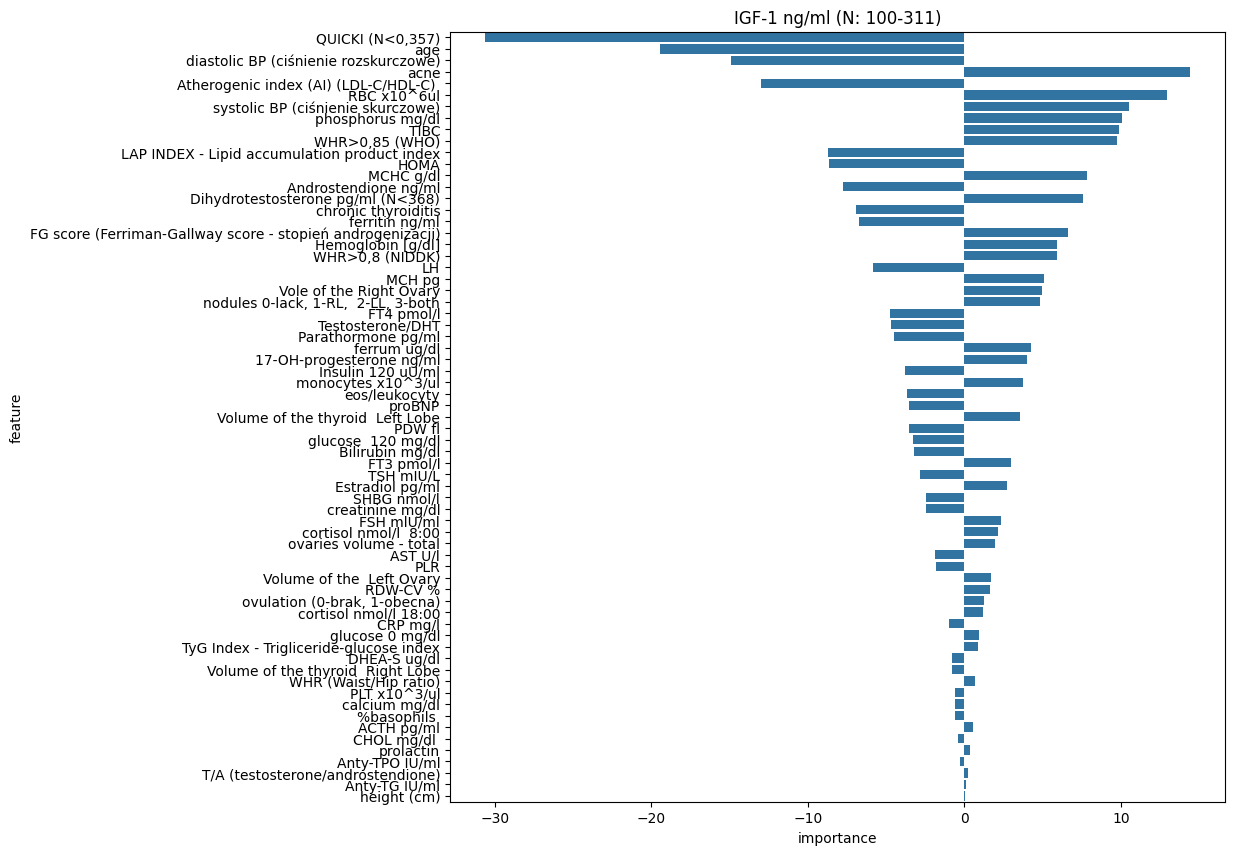

model  data_set       mse     mae    rmse     r2
0  Lasso(alpha=1)  training  3354.589  46.717  57.919  0.433
1  Lasso(alpha=1)      test  6676.362  61.961  81.709  0.014

In [8]:
lasso_model = Lasso(alpha=1)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


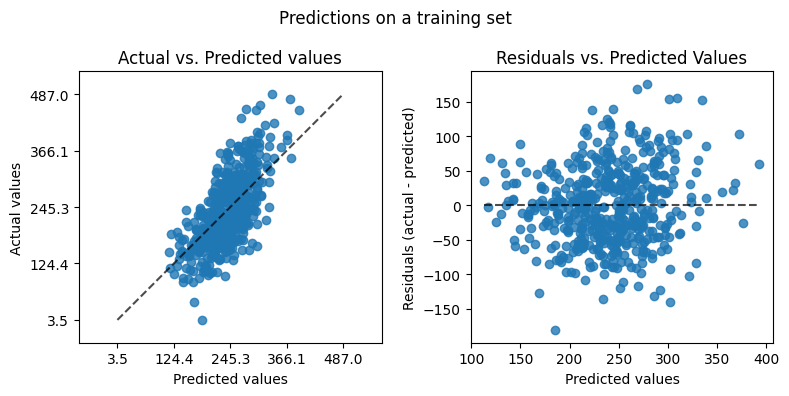

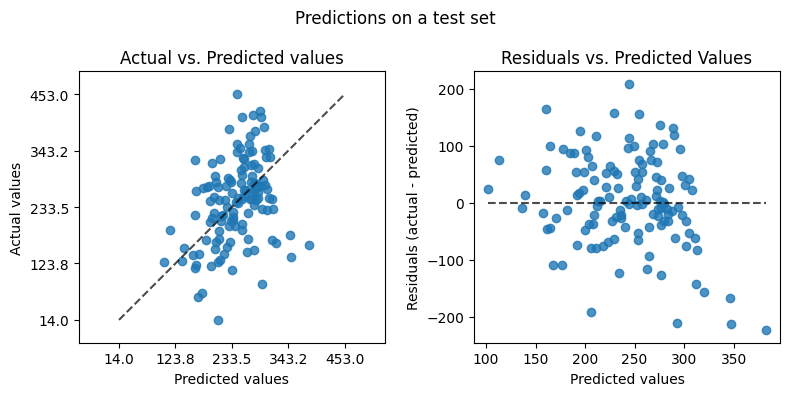

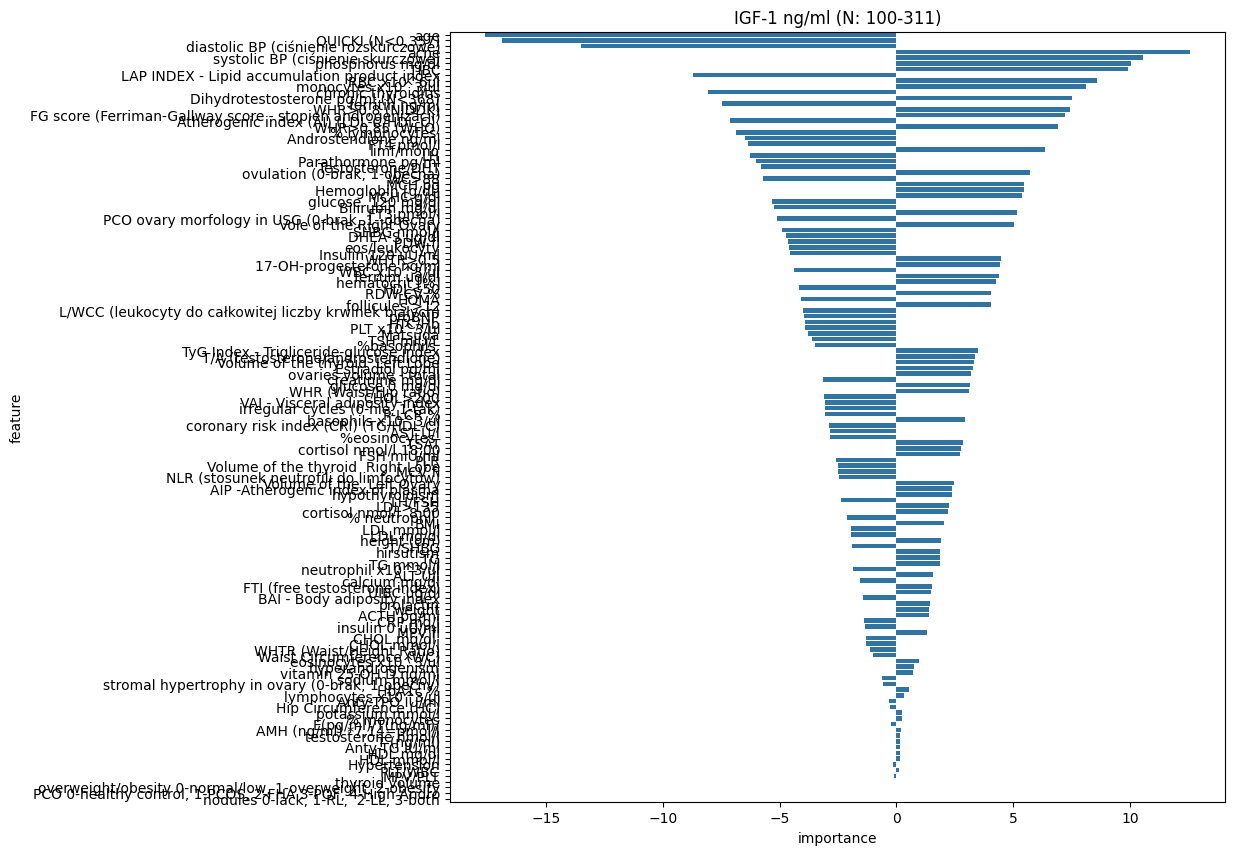

model  data_set       mse     mae    rmse     r2
0  Ridge(alpha=50)  training  3194.987  45.470  56.524  0.460
1  Ridge(alpha=50)      test  6395.880  61.348  79.974  0.055

In [9]:
ridge_model = Ridge(alpha=50)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


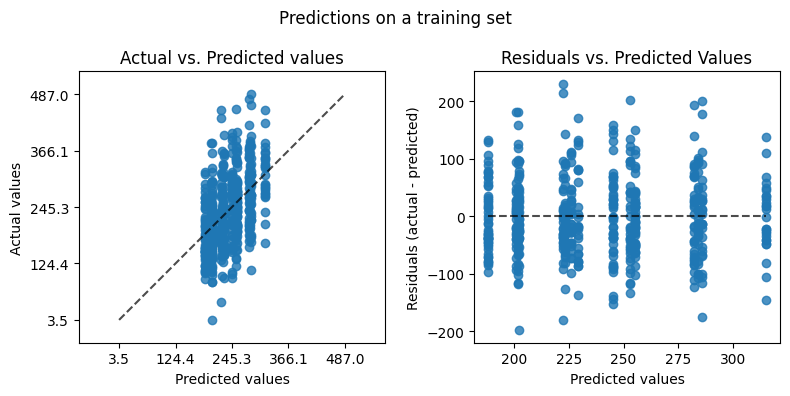

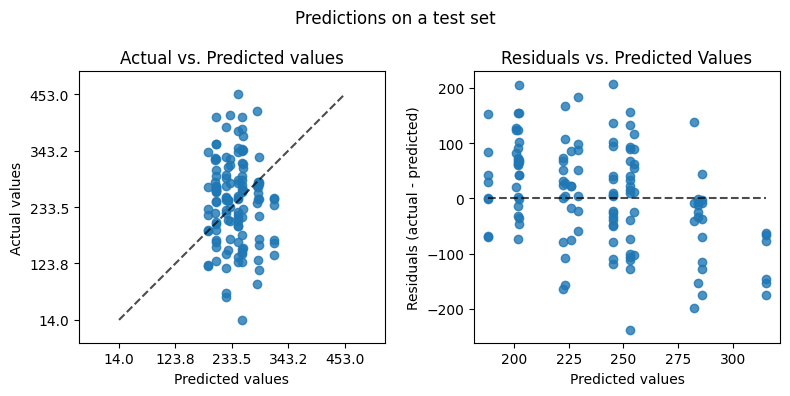

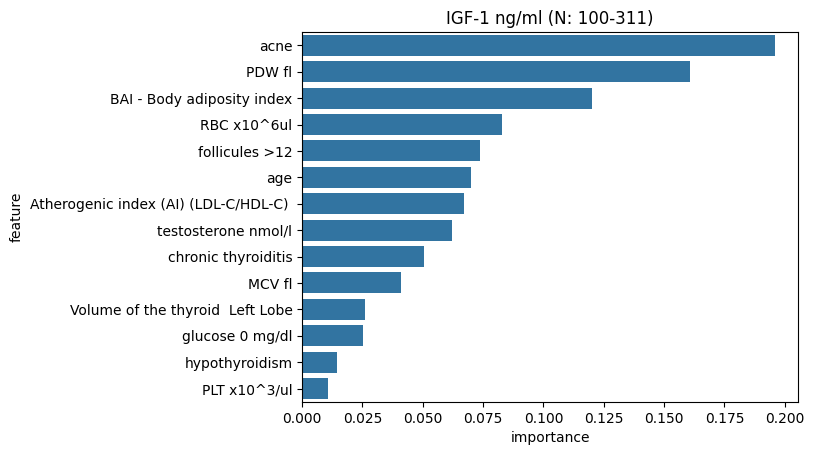

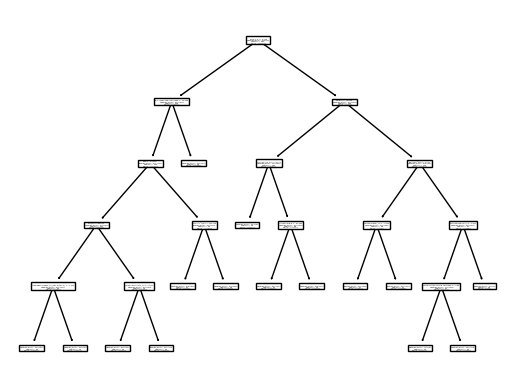

model  data_set       mse     mae    rmse     r2
0  DecisionTreeRegressor(max_depth=15, min_samples_leaf=25, min_samples_split=15,\n                      random_state=16, splitter='random')  training  4662.627  53.875  68.283  0.212
1  DecisionTreeRegressor(max_depth=15, min_samples_leaf=25, min_samples_split=15,\n                      random_state=16, splitter='random')      test  8219.034  72.604  90.659 -0.214

In [10]:
tree_model = DecisionTreeRegressor(criterion="squared_error", max_depth=15, min_samples_leaf=25, min_samples_split=15, splitter='random', random_state=16)
vit_d_model_scores_df, feature_importnces_tree = train_model(tree_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, tree_continuous_preprocessor, categorical_preprocessor, get_feature_importance_tree)
vit_d_model_scores_df

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


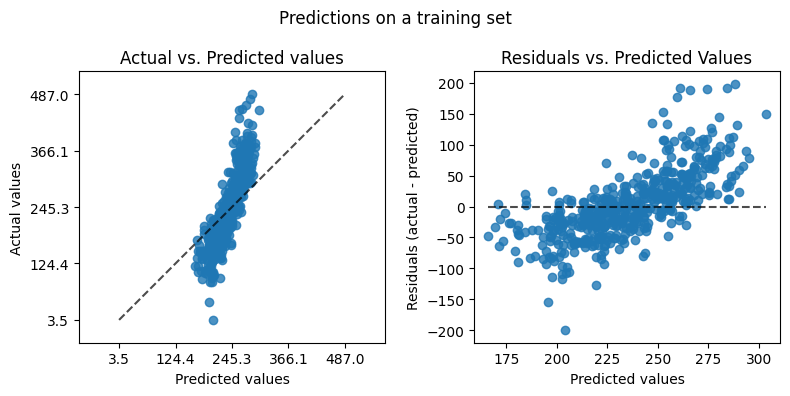

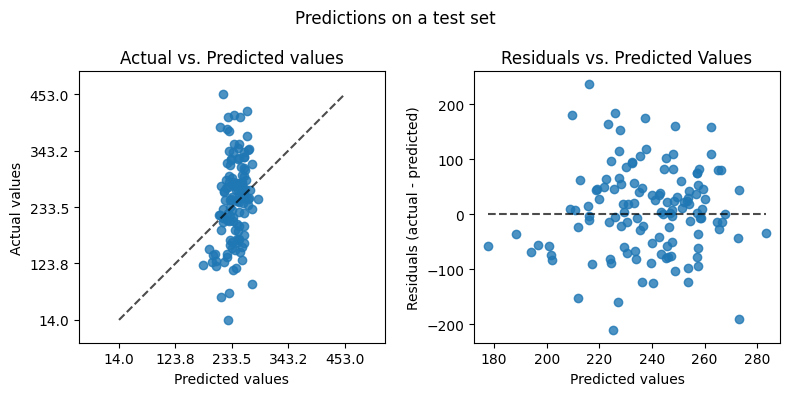

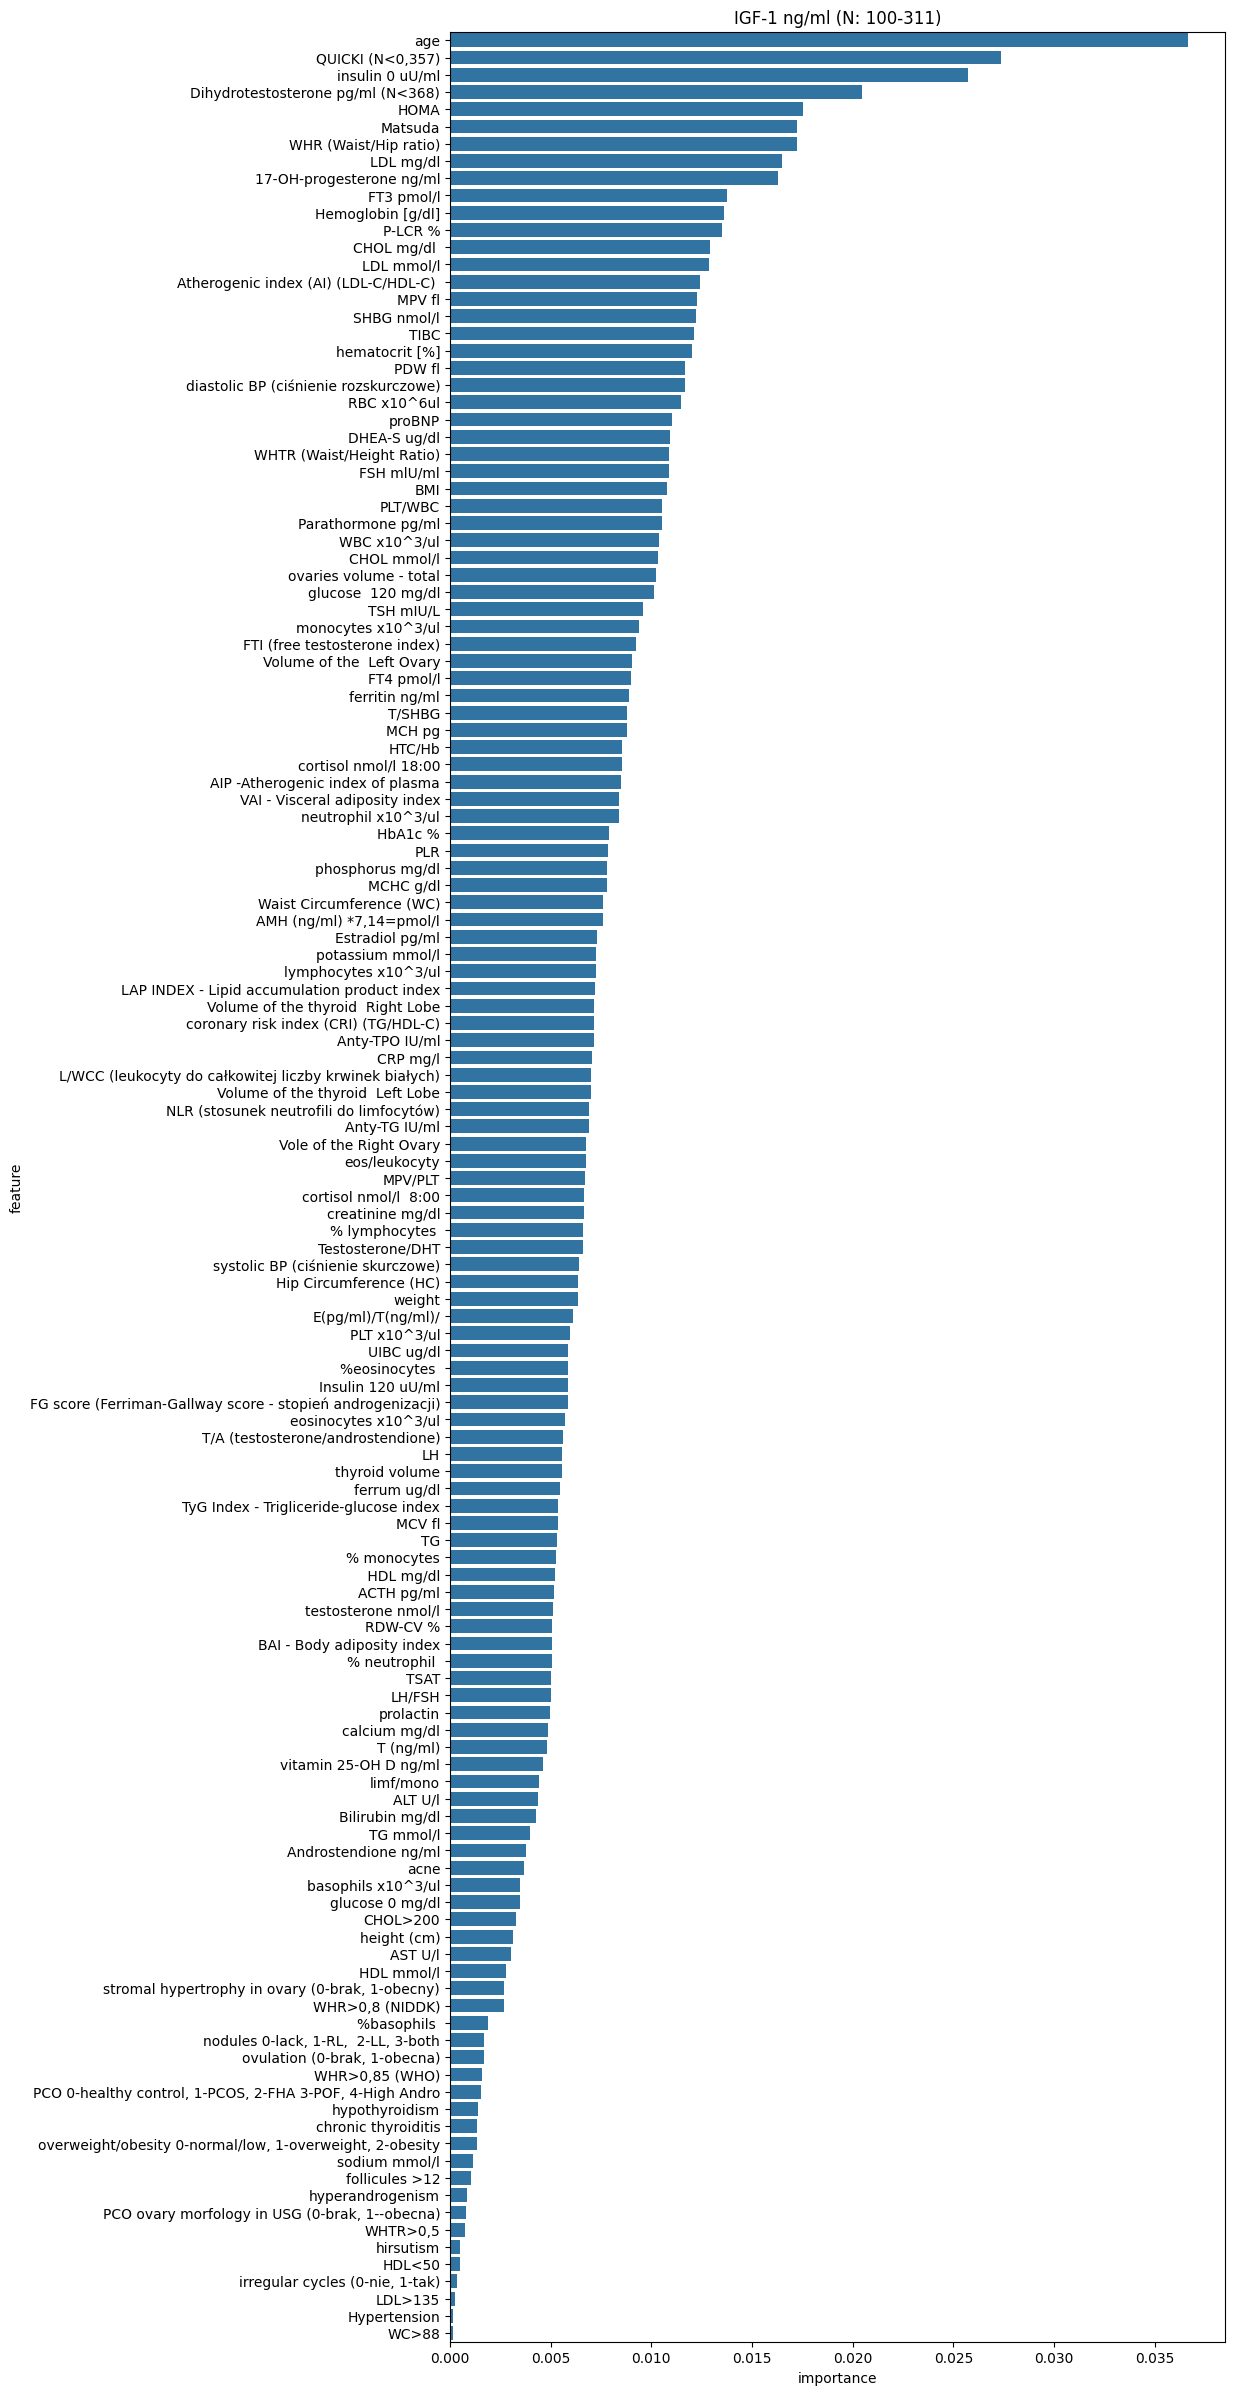

model  data_set       mse     mae    rmse     r2
0  RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n                      min_samples_leaf=7, min_samples_split=10,\n                      n_estimators=200, random_state=56)  training  3015.549  41.481  54.914  0.491
1  RandomForestRegressor(criterion='absolute_error', max_features='sqrt',\n                      min_samples_leaf=7, min_samples_split=10,\n                      n_estimators=200, random_state=56)      test  6320.412  61.932  79.501  0.066

In [11]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=56)

vit_d_model_scores_df, feature_importnces_rf = train_model(rf_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, tree_continuous_preprocessor, categorical_preprocessor, get_feature_importance_rf)
vit_d_model_scores_df

## Best models on subsets of data

In [12]:
index_features = [
    'LAP INDEX - Lipid accumulation product index',
    'VAI - Visceral adiposity index',
    'BAI - Body adiposity index',
    'TyG Index - Trigliceride-glucose index',
    'AIP -Atherogenic index of plasma',
    'Atherogenic index (AI) (LDL-C/HDL-C) ',
    'coronary risk index (CRI) (TG/HDL-C)',
    'FTI (free testosterone index)',
]



In [13]:
def difference_of_sets(set1, set2):
    return set(set1) - set(set2)

featureset_variations = {}

# without the obviously related features
cropped_featureset = difference_of_sets(X_igf.columns, igf_associated_features)
featureset_variations['cropped'] = cropped_featureset

#  inflammatory attributes
# inflammatory_featureset = difference_of_sets(inflammatory_attributes, igf_associated_features)
# featureset_variations['inflammatory'] = inflammatory_featureset

#  carbohydrate metabolism attributes
index_featureset = difference_of_sets(index_features, igf_associated_features)
featureset_variations['index'] = index_featureset

Featureset: cropped
Model: LinearRegression


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


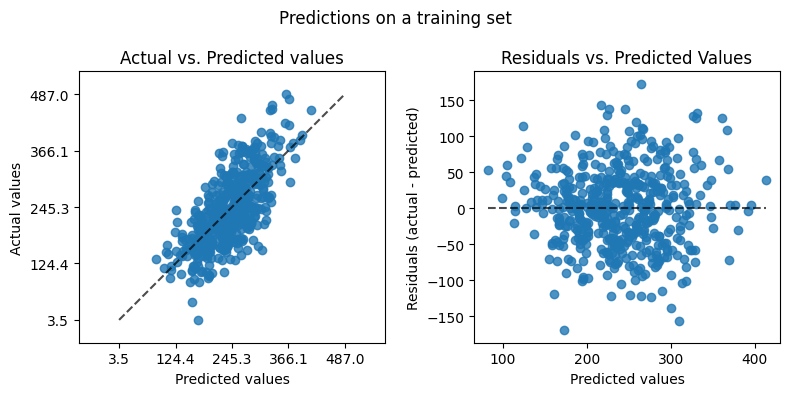

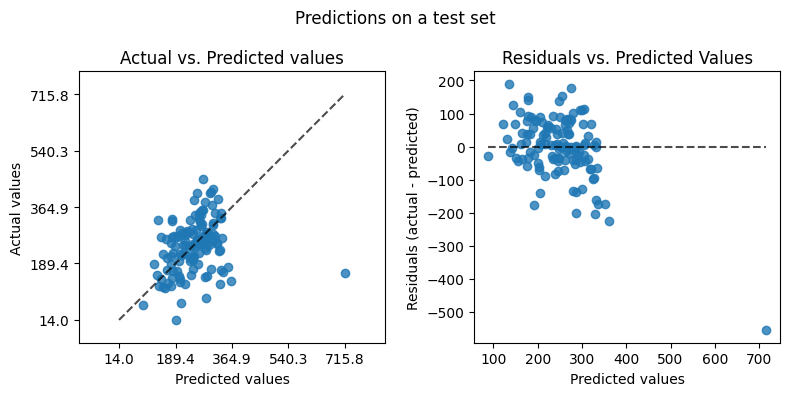

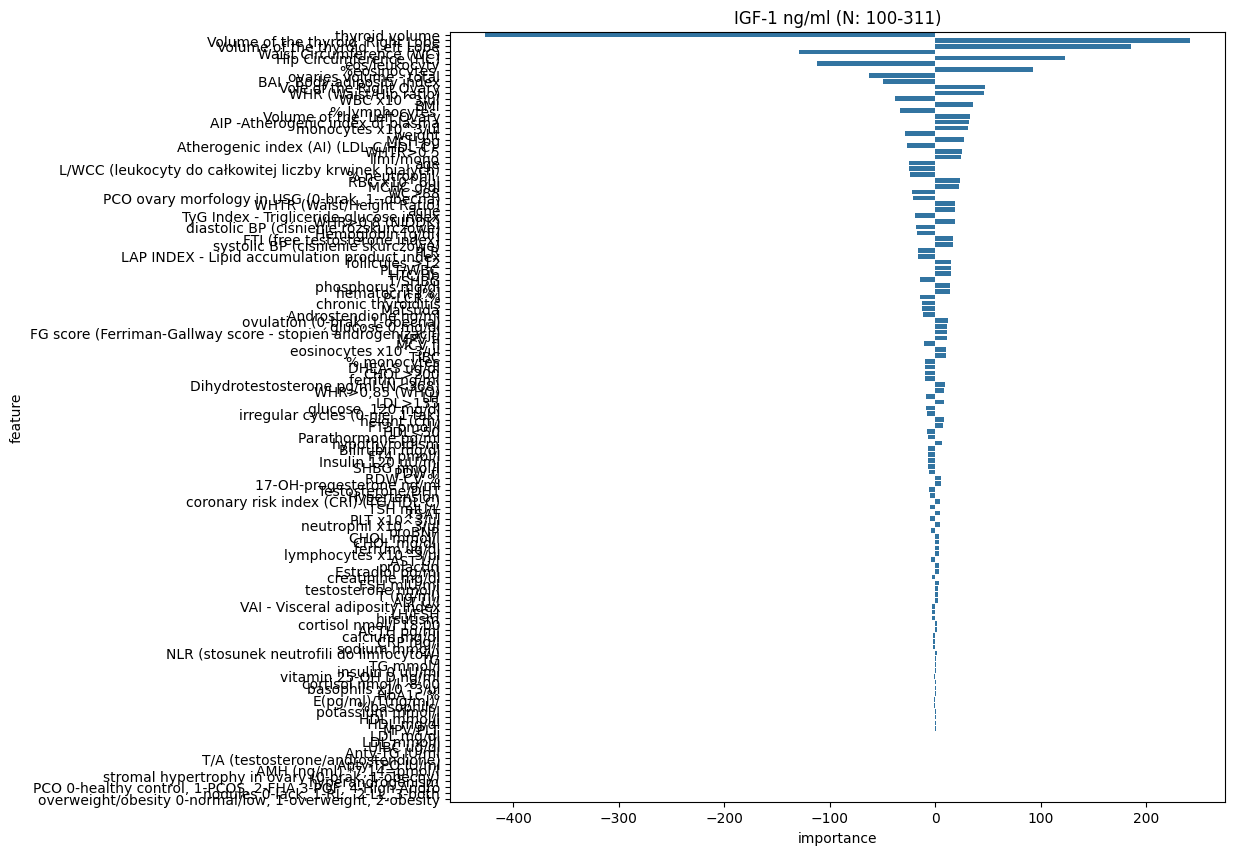

                model  data_set      mse     mae    rmse     r2
0  LinearRegression()  training  2939.50  43.090  54.217  0.503
1  LinearRegression()      test  8930.68  66.013  94.502 -0.319

Model: Lasso


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


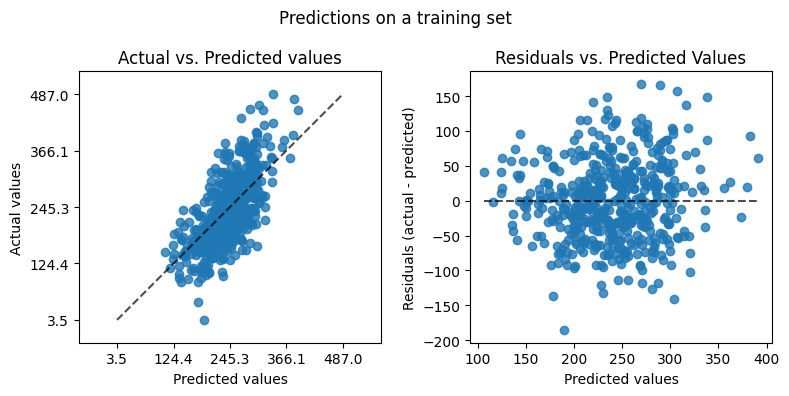

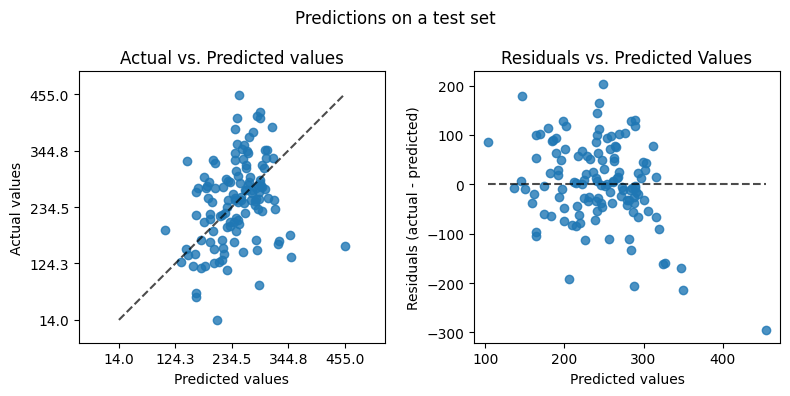

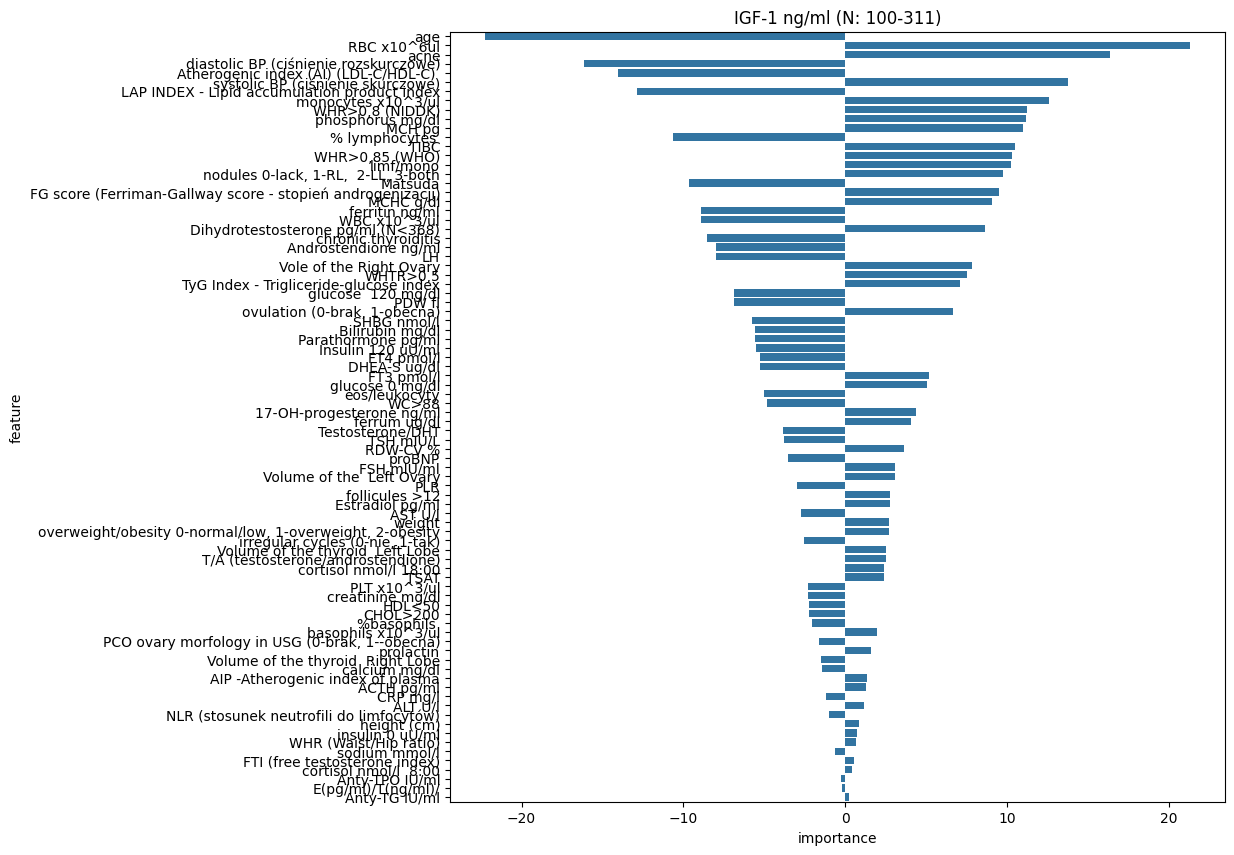

              model  data_set       mse     mae    rmse     r2
0  Lasso(alpha=0.5)  training  3202.505  45.370  56.591  0.459
1  Lasso(alpha=0.5)      test  6903.933  62.952  83.090 -0.020

Model: Ridge


c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


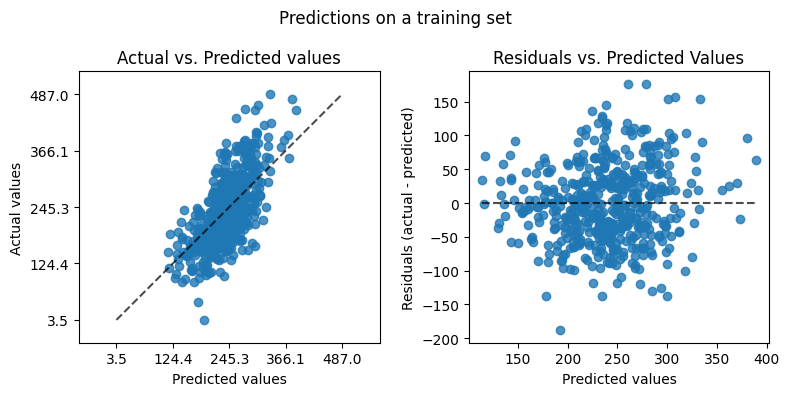

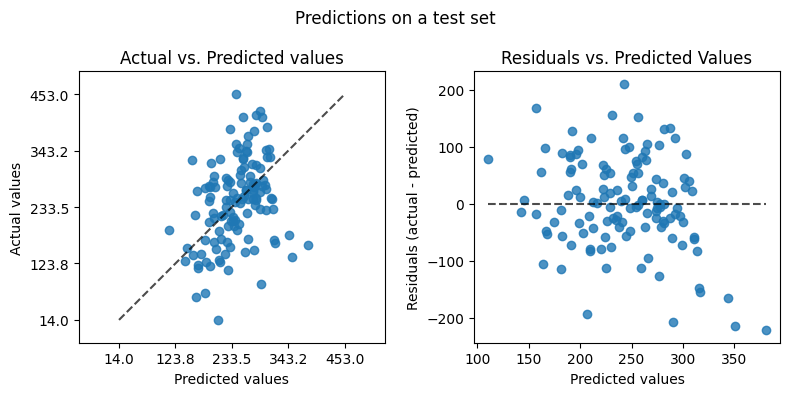

             model  data_set       mse     mae    rmse     r2
0  Ridge(alpha=50)  training  3260.934  45.774  57.105  0.449
1  Ridge(alpha=50)      test  6434.147  61.783  80.213  0.049

Featureset: index
Model: LinearRegression


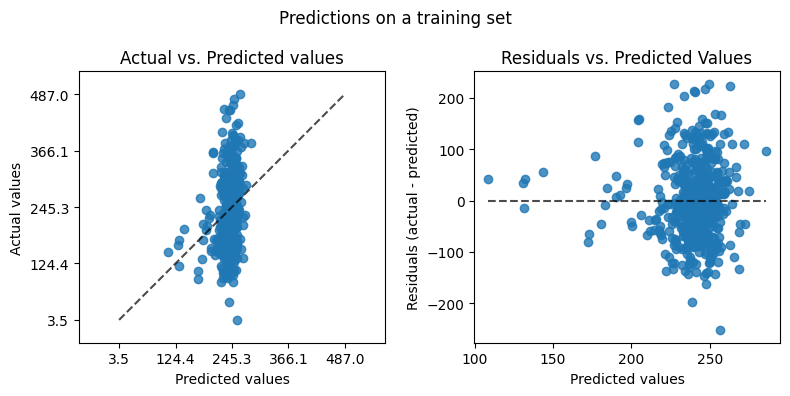

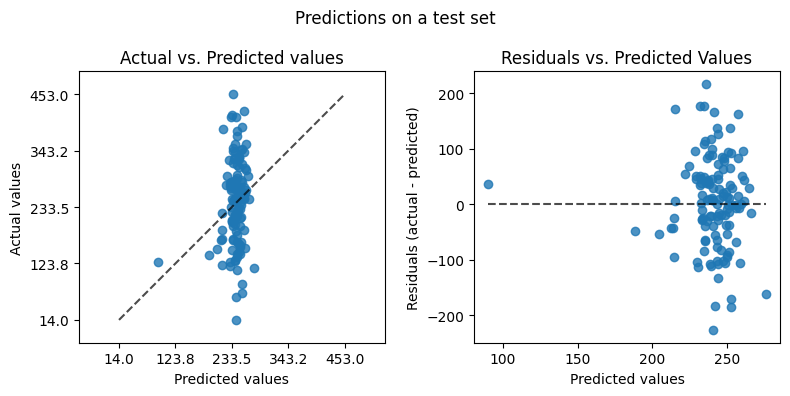

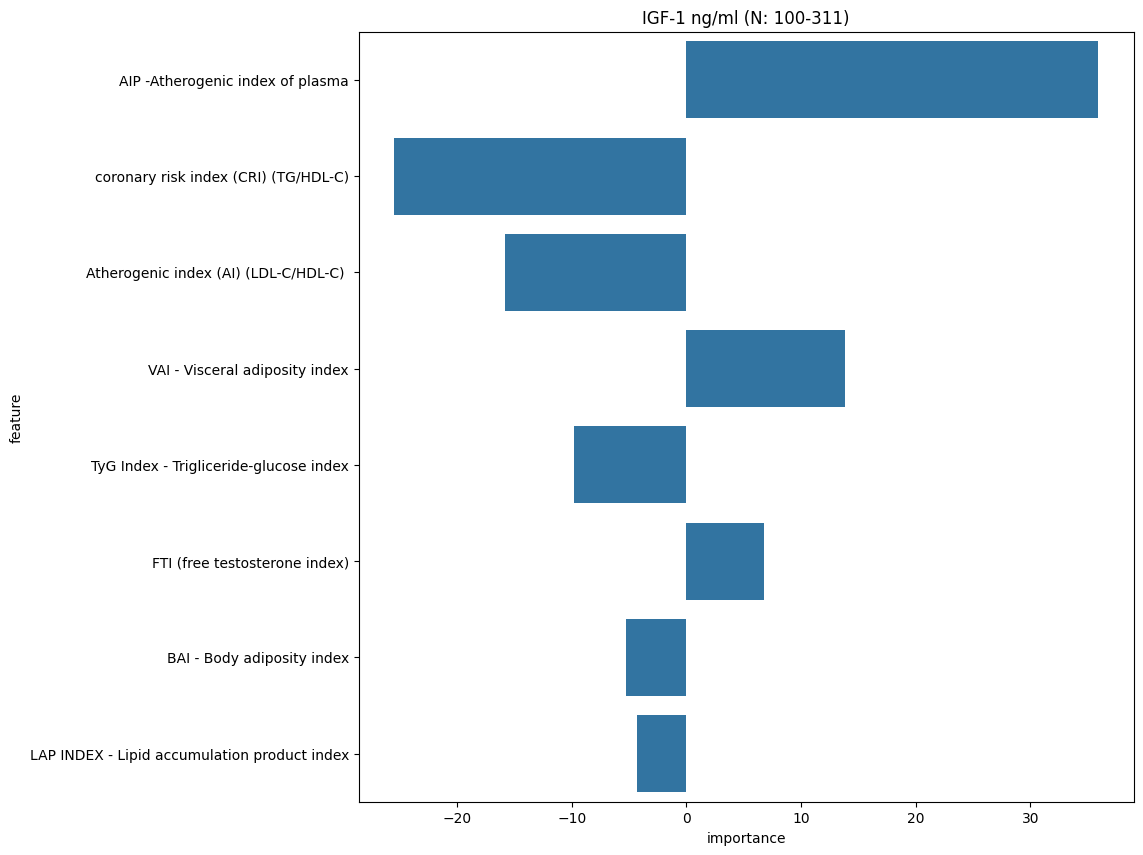

                model  data_set       mse     mae    rmse     r2
0  LinearRegression()  training  5588.598  59.589  74.757  0.056
1  LinearRegression()      test  6630.369  63.227  81.427  0.020

Model: Lasso


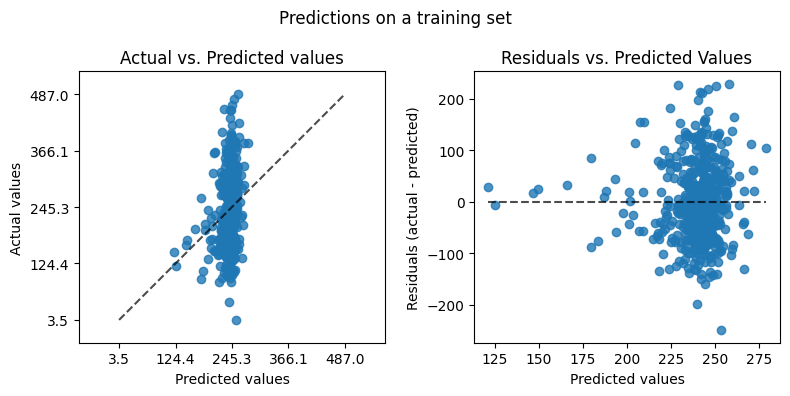

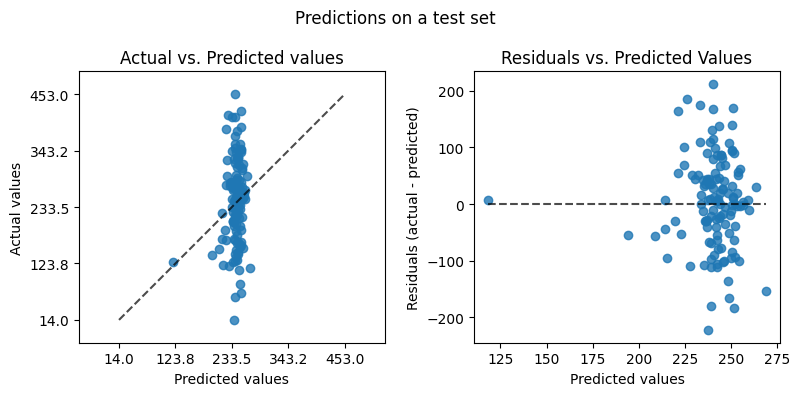

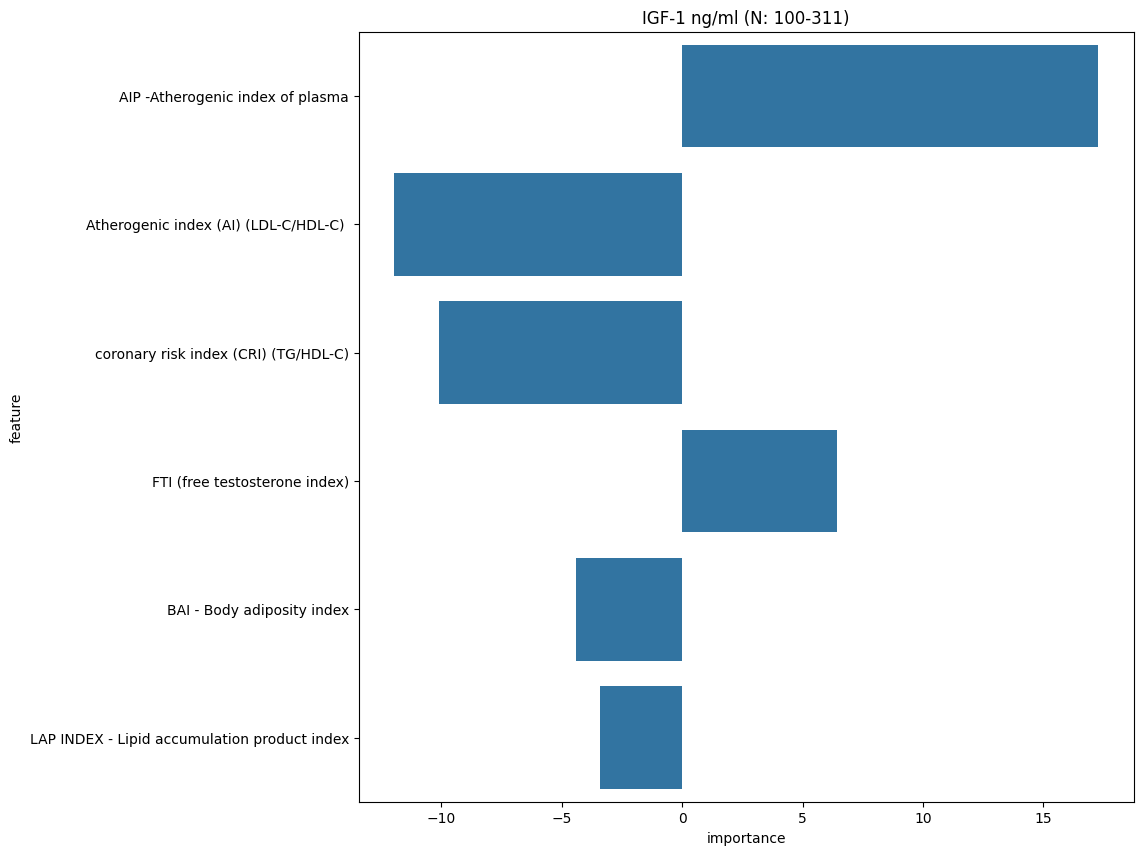

              model  data_set       mse     mae    rmse     r2
0  Lasso(alpha=0.5)  training  5606.108  59.669  74.874  0.053
1  Lasso(alpha=0.5)      test  6659.077  63.391  81.603  0.016

Model: Ridge


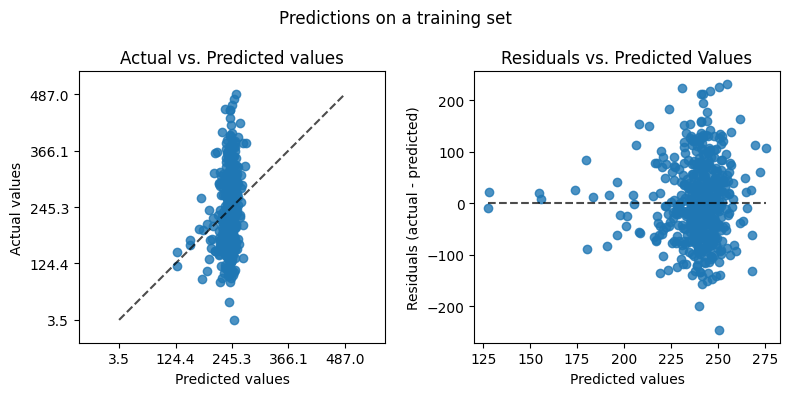

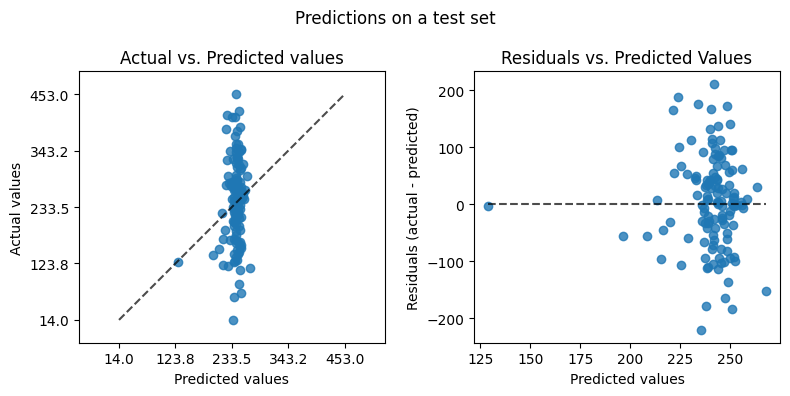

             model  data_set       mse     mae    rmse     r2
0  Ridge(alpha=50)  training  5623.789  59.749  74.992  0.050
1  Ridge(alpha=50)      test  6667.926  63.444  81.657  0.015



In [14]:
models = {
    'LinearRegression': (LinearRegression(), get_feature_importance_lasso, continuous_preprocessor),
    'Lasso': (Lasso(alpha=0.5), get_feature_importance_lasso, continuous_preprocessor),
    'Ridge': (Ridge(alpha=50), get_feature_importance_lasso, continuous_preprocessor),
    # 'DecisionTree': (DecisionTreeRegressor(criterion="absolute_error", max_depth=8, min_samples_leaf=27, min_samples_split=17, splitter='random', random_state=62), get_feature_importance_tree, tree_continuous_preprocessor),
    # 'RandomForest': (RandomForestRegressor(n_estimators=200, max_depth=None, max_features='sqrt', min_samples_leaf=7, min_samples_split=10, criterion='absolute_error', random_state=56), get_feature_importance_rf, tree_continuous_preprocessor),
    # 'KNN': (KNeighborsRegressor(n_neighbors=5), get_feature_importance_tree)
}


for featureset_name, featureset in featureset_variations.items():
    print(f"Featureset: {featureset_name}")
    X_featureset = X_igf[list(featureset)]
    X_train_featureset, X_test_featureset, y_train_featureset, y_test_featureset = train_test_split(X_featureset, y_igf, test_size=0.2, random_state=42)

    for model_name, (model, feature_importance_method, cont_preprocessor) in models.items():
        print(f"Model: {model_name}")
        model_scores_df, feature_importances = train_model(model, IGF, X_train_featureset, y_train_featureset, X_test_featureset, y_test_featureset, cont_preprocessor, categorical_preprocessor, feature_importance_method)
        print(model_scores_df)
        print()


## Feature importances

In [8]:
selected_features_map = {}

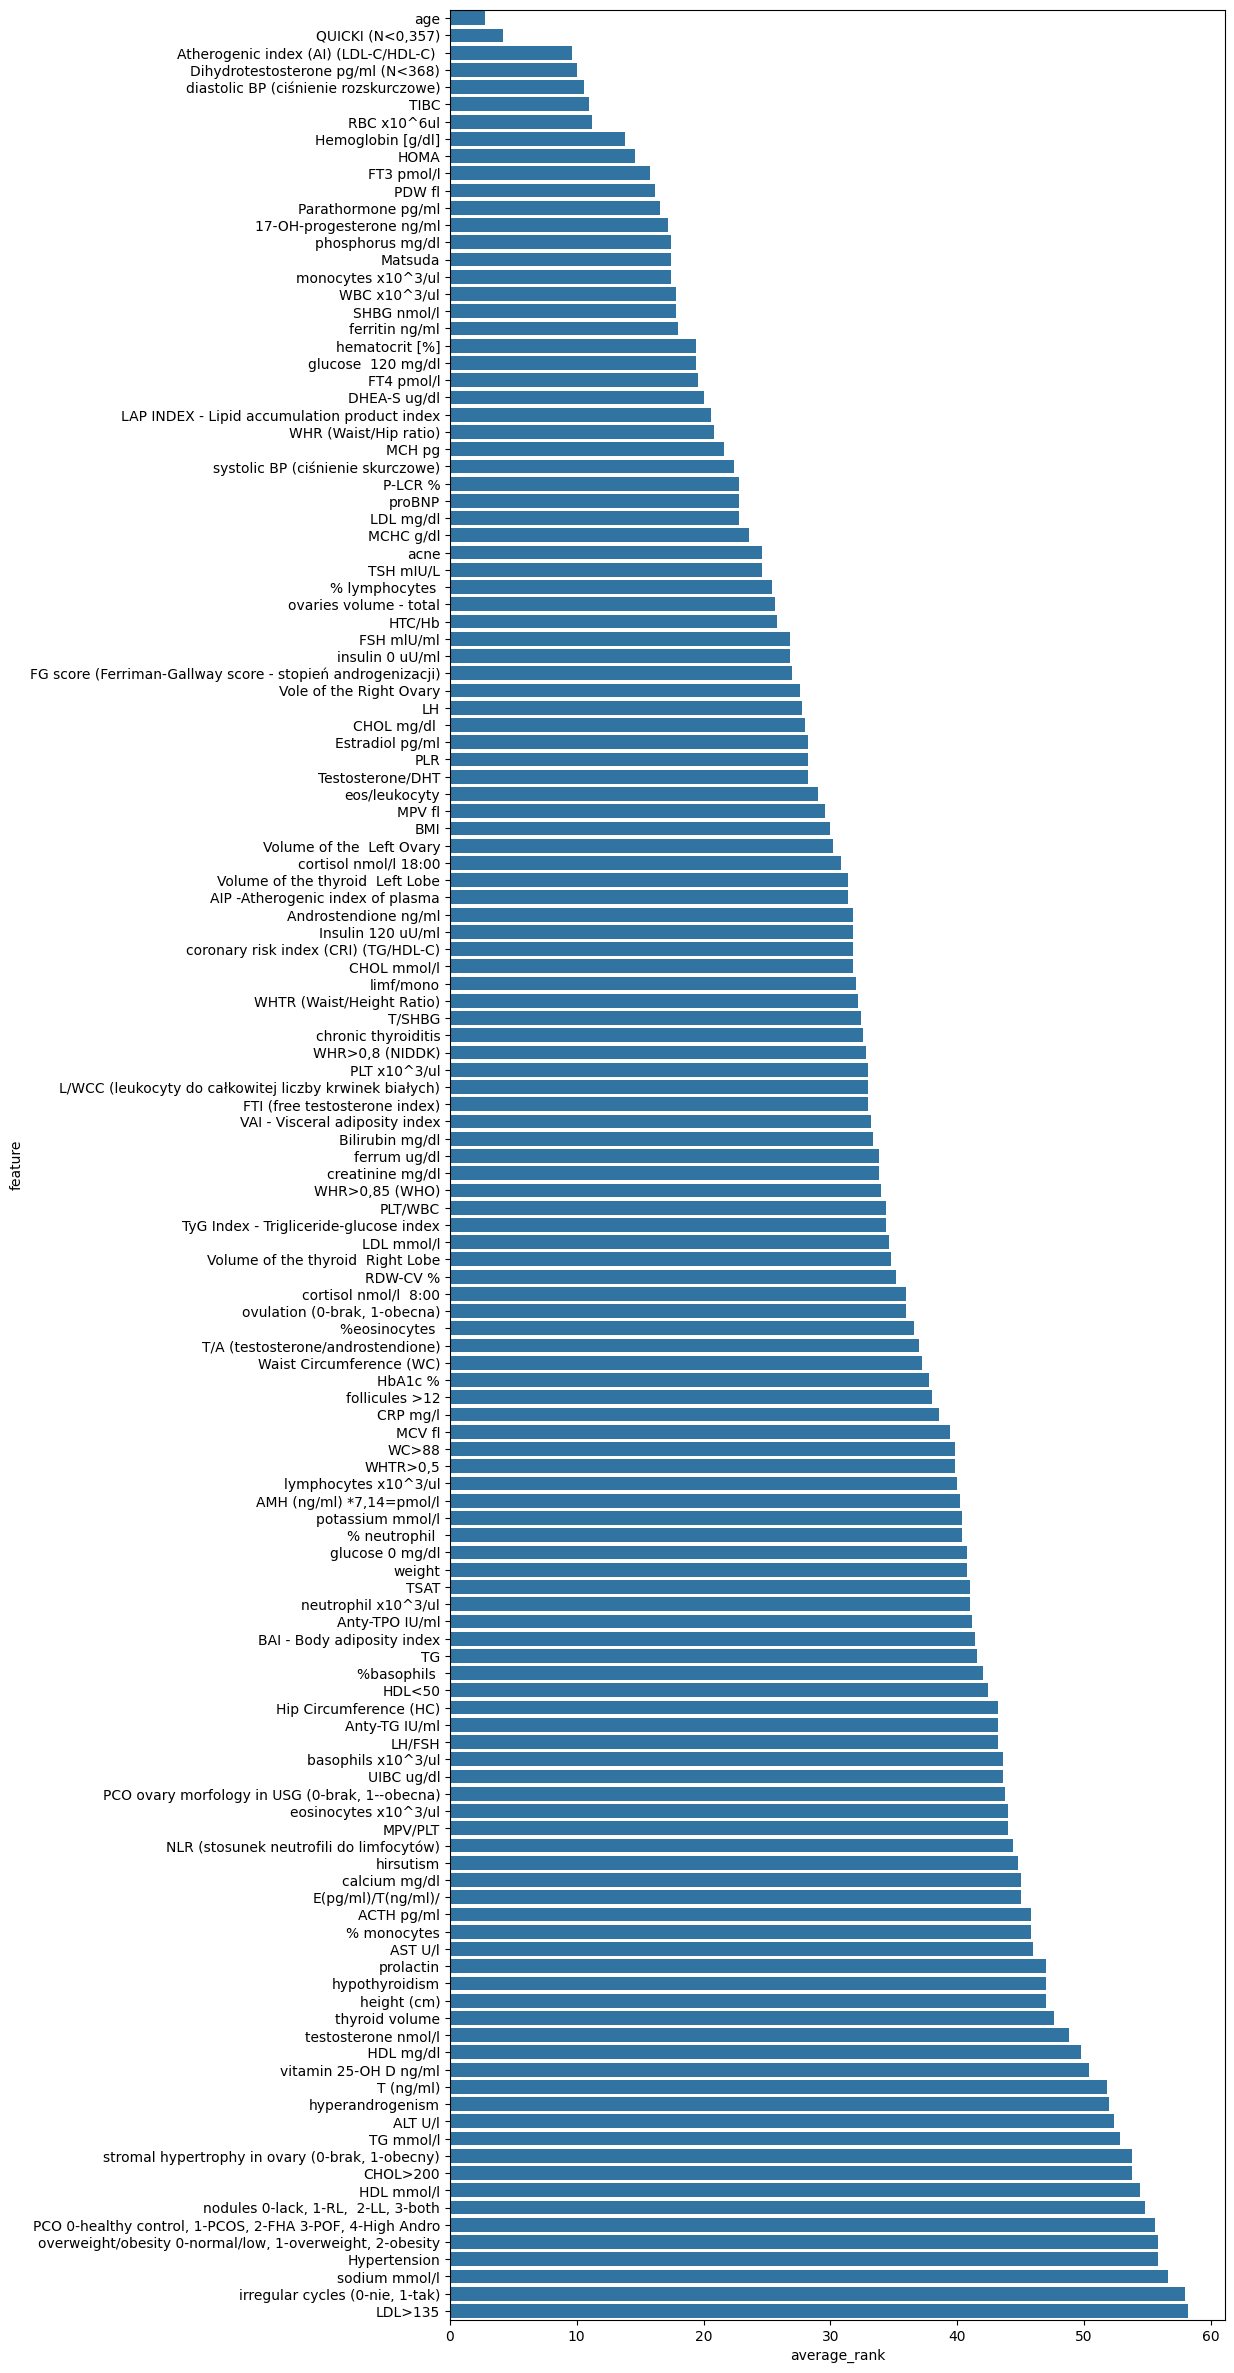

In [58]:
rename_importnace_col(feature_importnces_lr, 'linear_regression')
rename_importnace_col(feature_importnces_lasso, 'lasso')
rename_importnace_col(feature_importnces_ridge, 'ridge')
rename_importnace_col(feature_importnces_tree, 'tree')
rename_importnace_col(feature_importnces_rf, 'rf')

feature_importance_df = merge_feature_importances([feature_importnces_lr, feature_importnces_lasso, feature_importnces_ridge, feature_importnces_tree, feature_importnces_rf])

ranked_df = rank_importances(feature_importance_df)
ranked_df_sorted = ranked_df.sort_values(by='average_rank')

plt.figure(figsize=(10, 30))
sns.barplot(ranked_df_sorted, x="average_rank", y="feature")
plt.show()

In [59]:
overall_rank_top_features = ranked_df_sorted[ranked_df_sorted['average_rank'] < 30] # a cut found on the plot above
overall_rank_selected_features = list(overall_rank_top_features['feature'].values)

selected_features_map['average_rank'] = overall_rank_selected_features
print(f'Top {len(overall_rank_selected_features)} features:')
overall_rank_selected_features

Top 47 features:


['age',
 'QUICKI (N<0,357)',
 'Atherogenic index (AI) (LDL-C/HDL-C) ',
 'Dihydrotestosterone pg/ml (N<368)',
 'diastolic BP (ciśnienie rozskurczowe)',
 'TIBC',
 'RBC x10^6ul',
 'Hemoglobin [g/dl]',
 'HOMA',
 'FT3 pmol/l',
 'PDW fl',
 'Parathormone pg/ml',
 '17-OH-progesterone ng/ml',
 'phosphorus mg/dl',
 'Matsuda',
 'monocytes x10^3/ul',
 'WBC x10^3/ul',
 'SHBG nmol/l',
 'ferritin ng/ml',
 'hematocrit [%]',
 'glucose  120 mg/dl',
 'FT4 pmol/l',
 'DHEA-S ug/dl',
 'LAP INDEX - Lipid accumulation product index',
 'WHR (Waist/Hip ratio)',
 'MCH pg',
 'systolic BP (ciśnienie skurczowe)',
 'P-LCR %',
 'proBNP',
 'LDL mg/dl',
 'MCHC g/dl',
 'acne',
 'TSH mIU/L',
 '% lymphocytes ',
 'ovaries volume - total',
 'HTC/Hb',
 'FSH mlU/ml',
 'insulin 0 uU/ml',
 'FG score (Ferriman-Gallway score - stopień androgenizacji)',
 'Vole of the Right Ovary',
 'LH',
 'CHOL mg/dl ',
 'Estradiol pg/ml',
 'PLR',
 'Testosterone/DHT',
 'eos/leukocyty',
 'MPV fl']

## Feature selection methods

### Mutual info

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


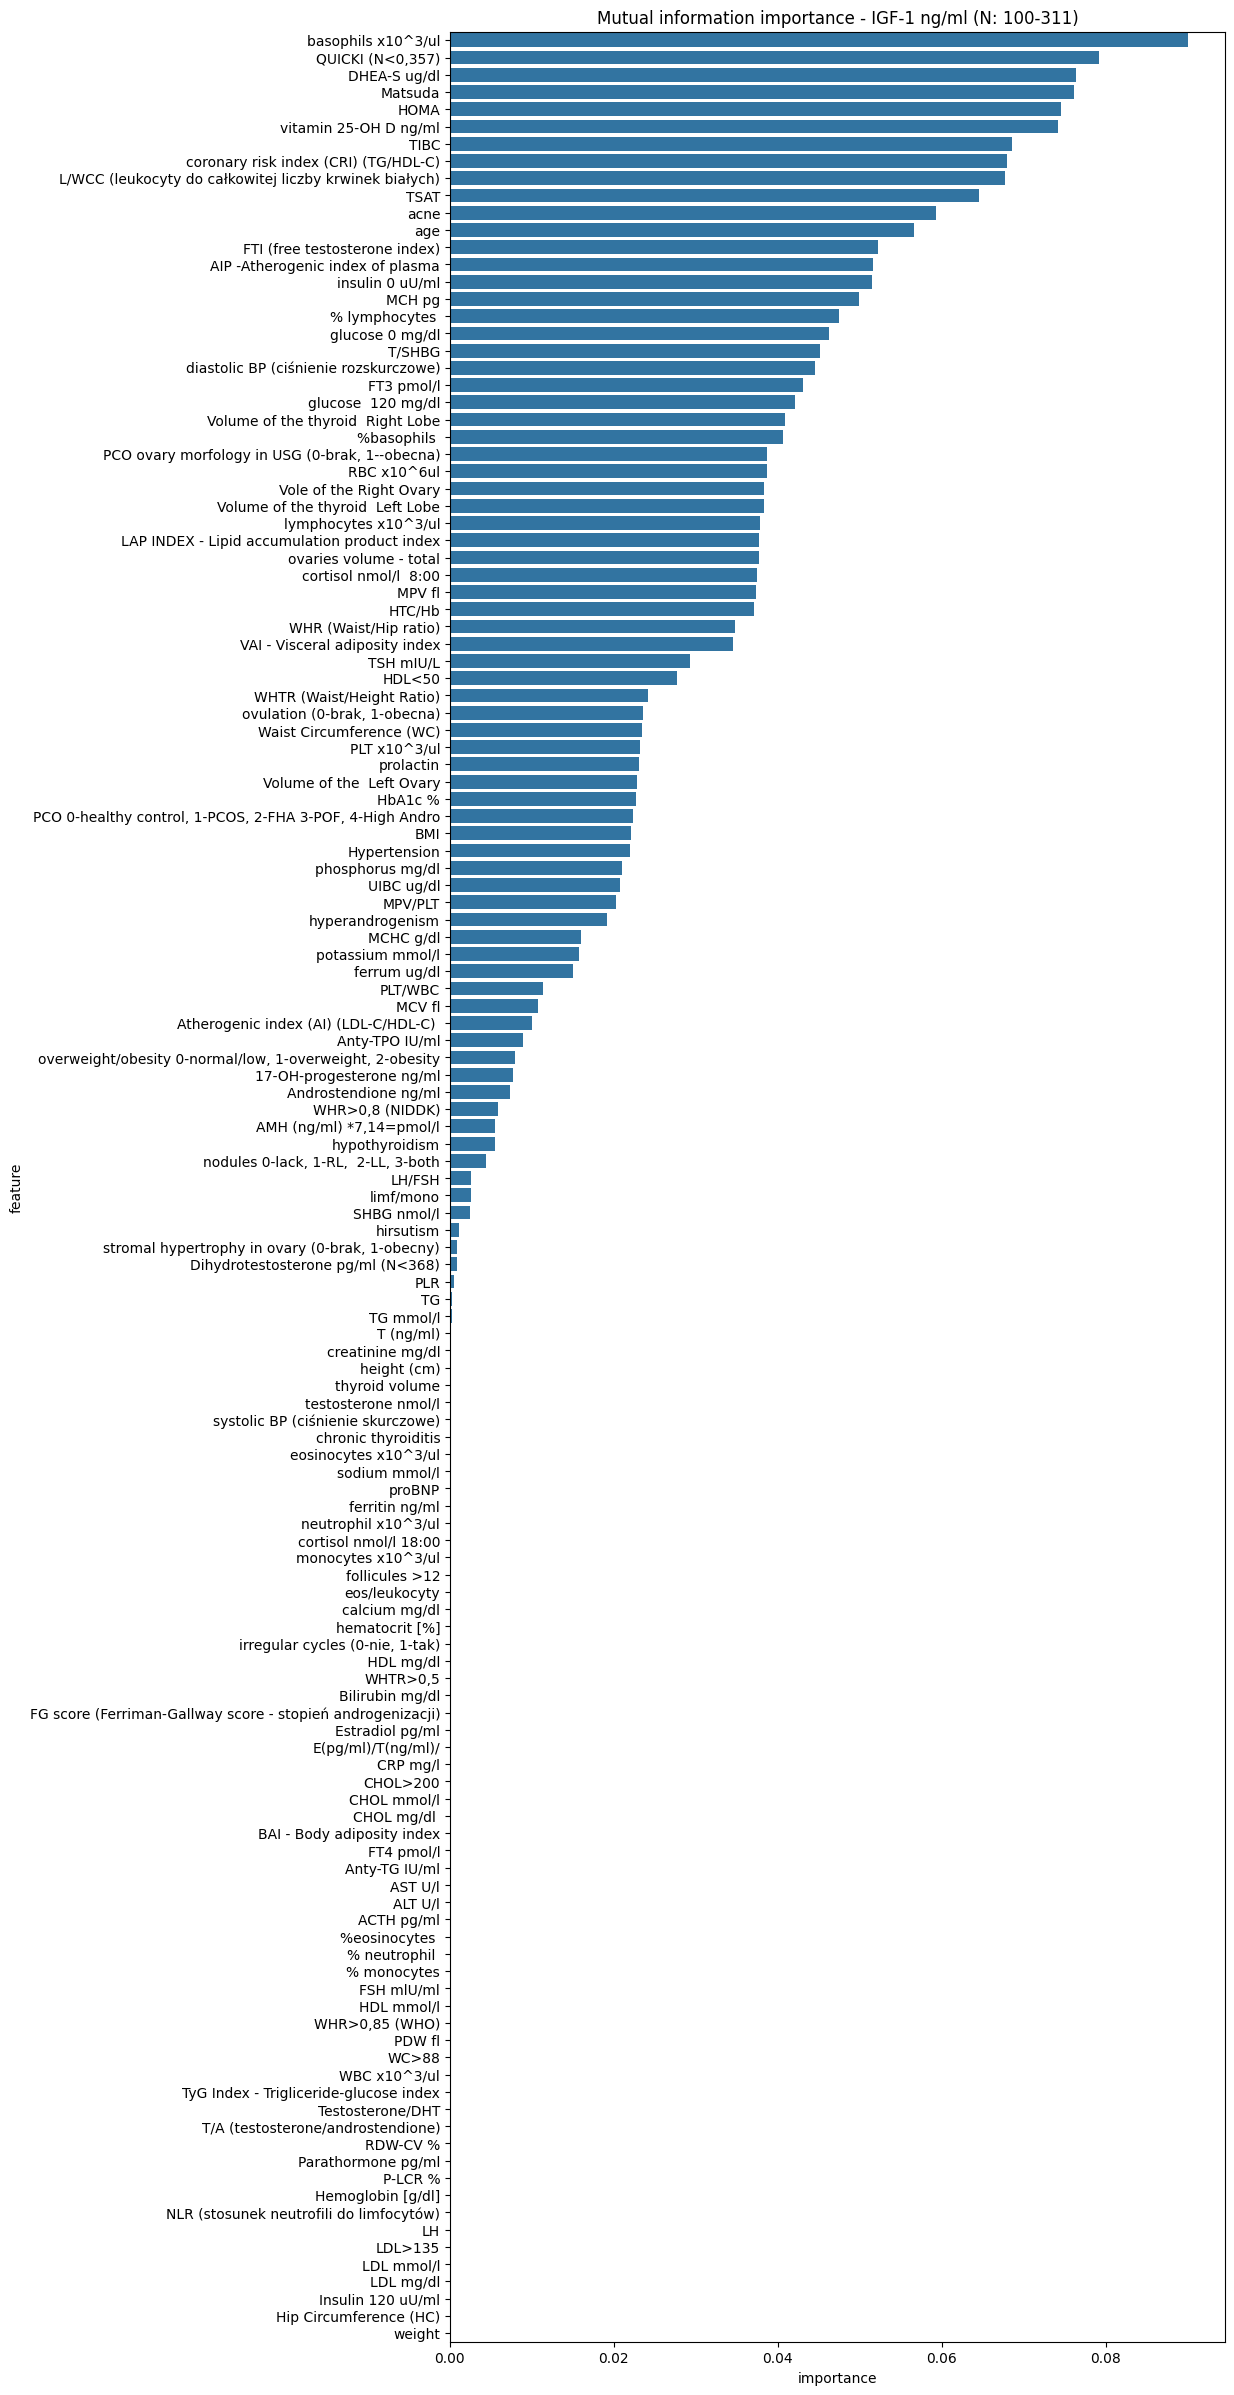

Selected 76 features


In [9]:
selected_feature_names_mutual_info = feature_selection_mutual_info_regression(X_train_igf, y_train_igf, IGF, continuous_preprocessor, categorical_preprocessor)
selected_feature_names_mutual_info = selected_feature_names_mutual_info[selected_feature_names_mutual_info['importance'] > 0]

selected_feature_names_mutual_info.reset_index(drop=True, inplace=True)
print(f'Selected {len(selected_feature_names_mutual_info)} features')
selected_features_map['mutual_info'] = list(selected_feature_names_mutual_info['feature'].values)
# selected_feature_names_mutual_info

### Recursive feature elimination

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Optimal number of features: 23


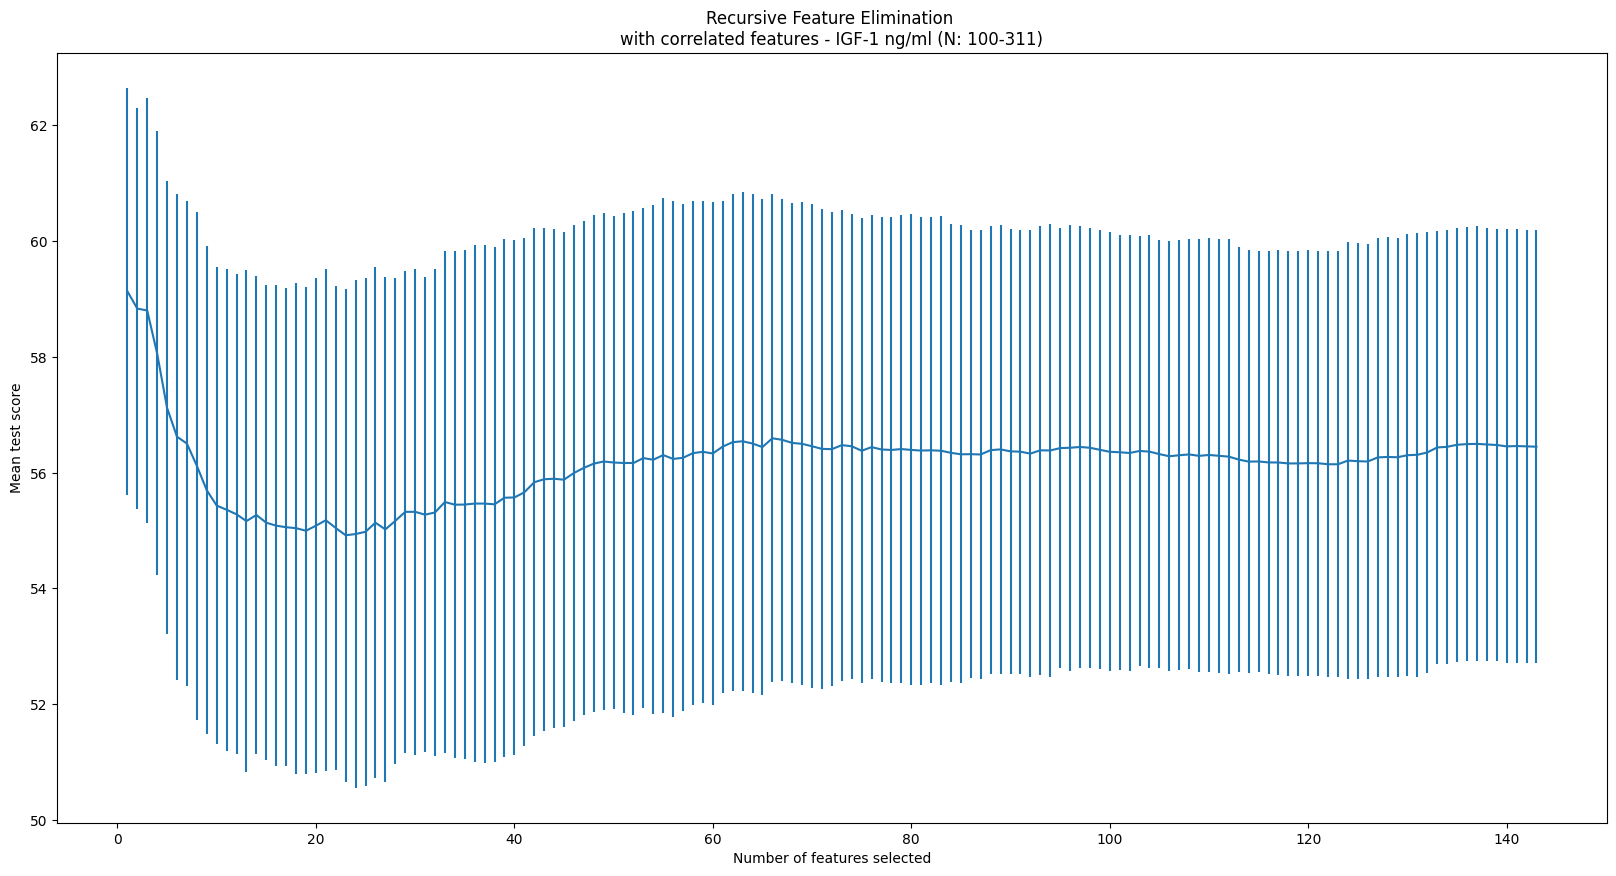

['LAP INDEX - Lipid accumulation product index',
 'QUICKI (N<0,357)',
 'Dihydrotestosterone pg/ml (N<368)',
 'RBC x10^6ul',
 'TIBC',
 'MCH pg',
 'overweight/obesity 0-normal/low, 1-overweight, 2-obesity',
 'WHR>0,8 (NIDDK)',
 'Atherogenic index (AI) (LDL-C/HDL-C) ',
 'FG score (Ferriman-Gallway score - stopień androgenizacji)',
 'glucose  120 mg/dl',
 'Androstendione ng/ml',
 'phosphorus mg/dl',
 'acne',
 'age',
 'chronic thyroiditis',
 'diastolic BP (ciśnienie rozskurczowe)',
 'ferritin ng/ml',
 'nodules 0-lack, 1-RL,  2-LL, 3-both',
 'systolic BP (ciśnienie skurczowe)',
 'Hemoglobin [g/dl]',
 'WHR>0,85 (WHO)',
 'Parathormone pg/ml']

In [73]:
# lasso_model = Lasso(alpha=1)
lasso_model = Ridge(alpha=50)

recursive_feature_elimination_ranked_features_lasso = recursive_feature_elimination(X_train_igf, y_train_igf, lasso_model, IGF, continuous_preprocessor, categorical_preprocessor)
selected_features_map['recursive_feature_elimination'] = list(recursive_feature_elimination_ranked_features_lasso[recursive_feature_elimination_ranked_features_lasso['ranking'] == 1]['feature'].values)
selected_features_map['recursive_feature_elimination']

In [61]:
lasso_model = Lasso(alpha=1)
# lasso_model = Ridge(alpha=50)

recursive_feature_elimination_ranked_features_lasso = recursive_feature_elimination(X_train_igf, y_train_igf, lasso_model, IGF, continuous_preprocessor, categorical_preprocessor)
selected_features_map['recursive_feature_elimination'] = list(recursive_feature_elimination_ranked_features_lasso[recursive_feature_elimination_ranked_features_lasso['ranking'] == 1]['feature'].values)
selected_features_map['recursive_feature_elimination']

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Optimal number of features: 12


['TIBC',
 'chronic thyroiditis',
 'age',
 'acne',
 'HOMA',
 'Atherogenic index (AI) (LDL-C/HDL-C) ',
 'diastolic BP (ciśnienie rozskurczowe)',
 'phosphorus mg/dl',
 'WHR>0,85 (WHO)',
 'Hemoglobin [g/dl]',
 'systolic BP (ciśnienie skurczowe)',
 'QUICKI (N<0,357)']

### Permutation importance

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.


selected 68 features


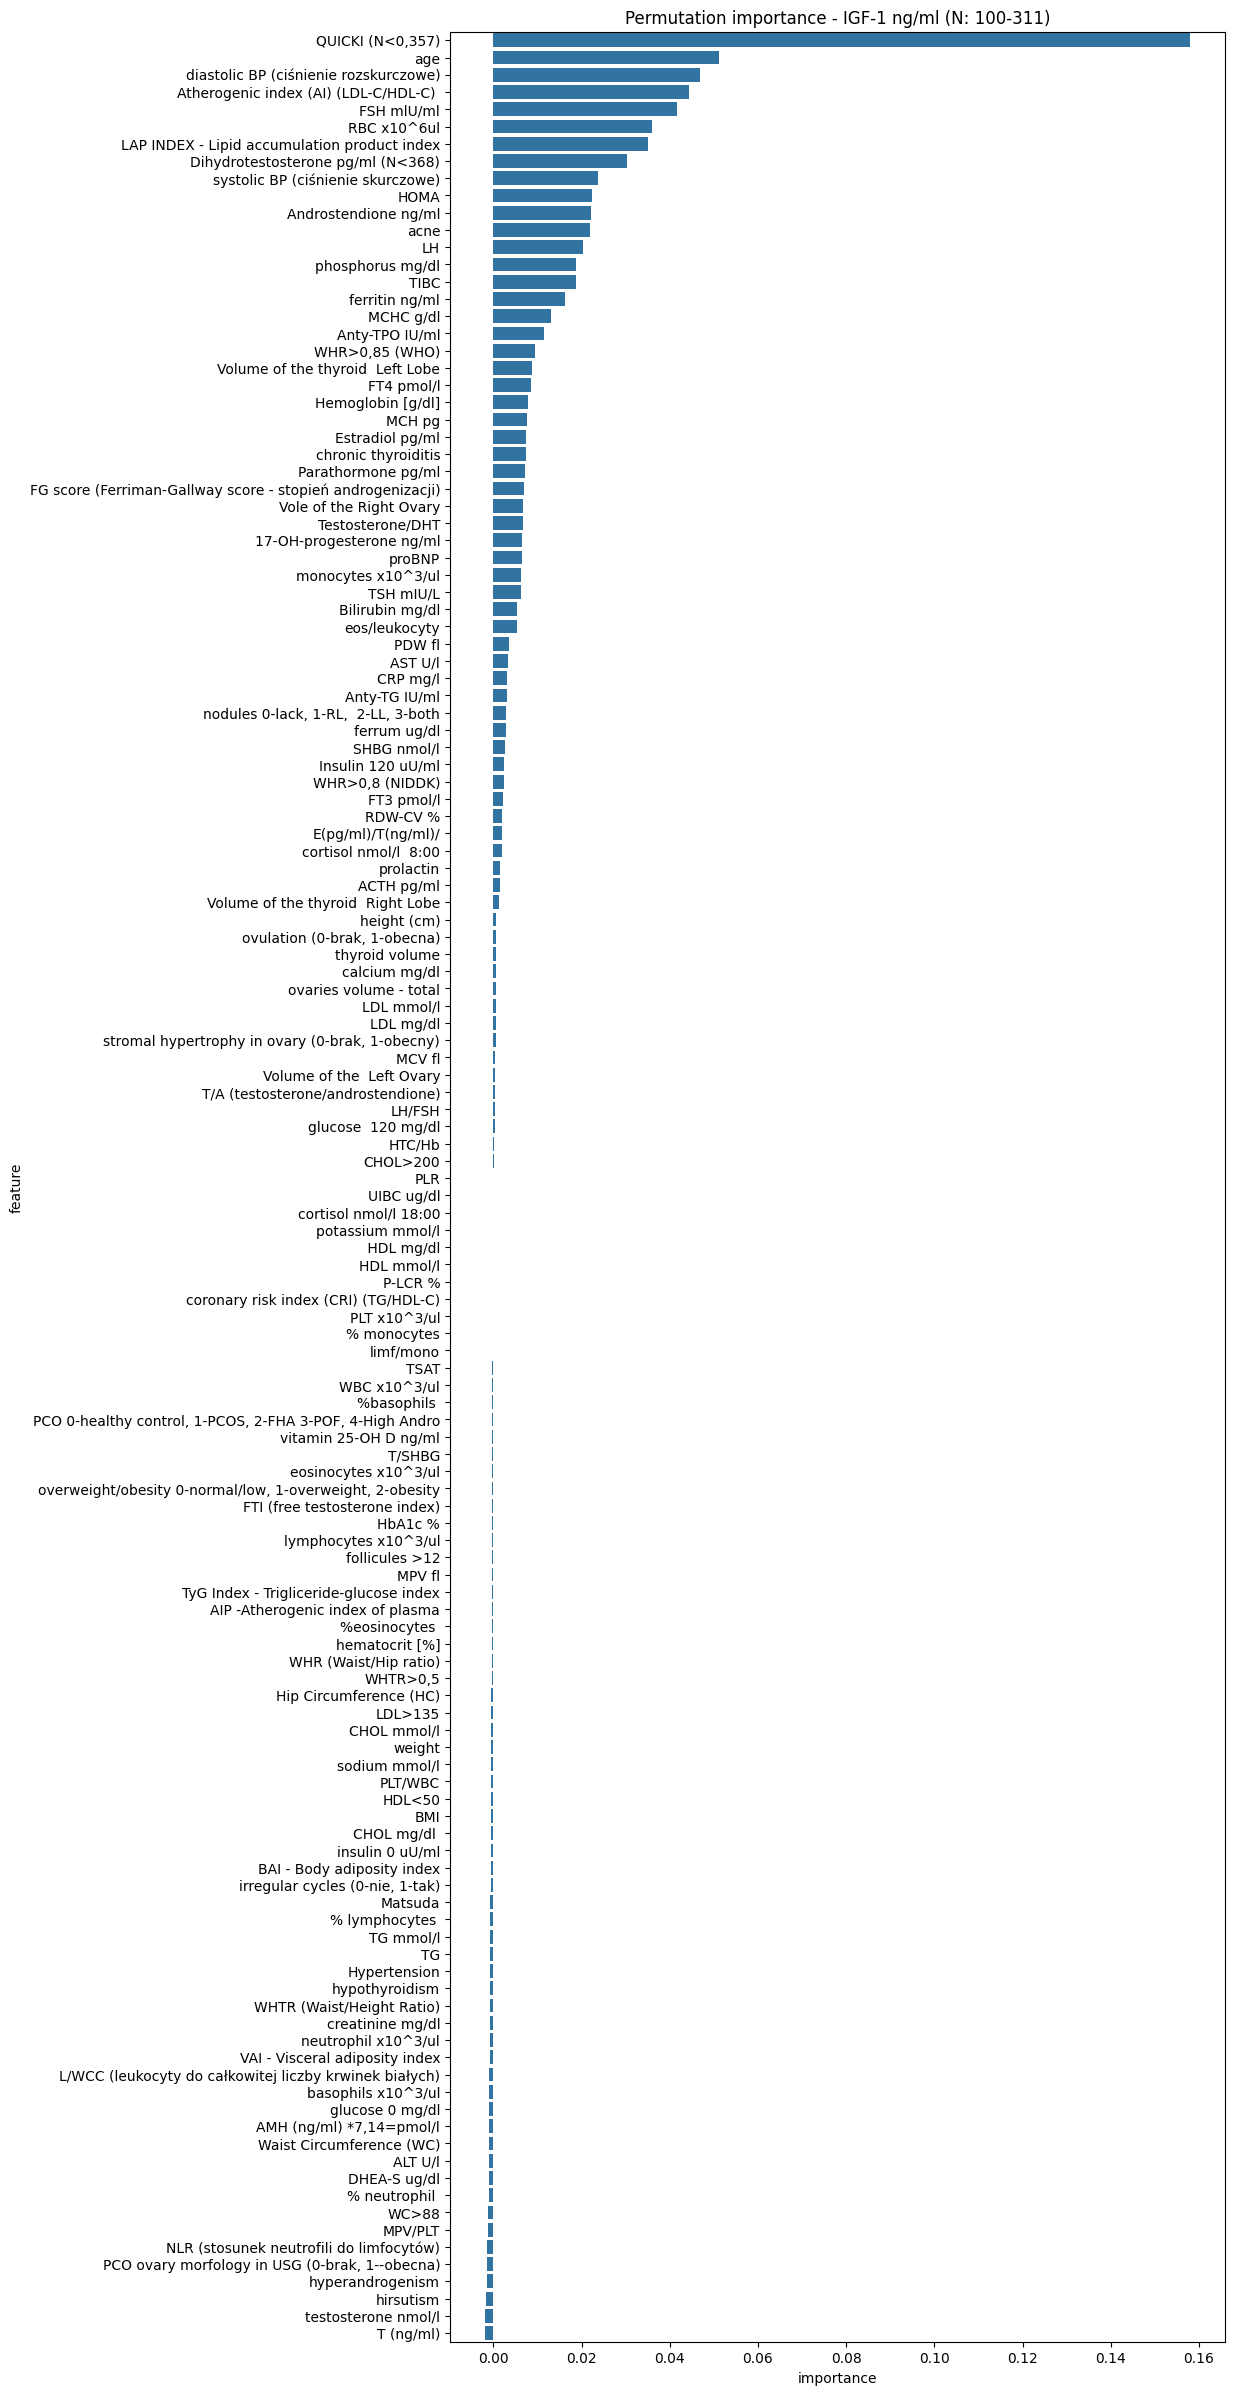

Actually selected 68 features


In [11]:
lasso_model = Lasso(alpha=1)

selected_features_permutation_importance = get_permutation_importance(X_train_igf, y_train_igf, lasso_model, continuous_preprocessor, categorical_preprocessor, IGF)
selected_features_permutation_importance = selected_features_permutation_importance[selected_features_permutation_importance['importance'] > 0]
selected_features_map['permutation_importance'] = list(selected_features_permutation_importance['feature'].values)
print(f'Actually selected {len(selected_features_map['permutation_importance'])} features')
# selected_features_permutation_importance

In [12]:
#  only mutual info &  permutation importance
intersection_all_sets = set(selected_features_map[next(iter(selected_features_map))])

for key, items in selected_features_map.items():
    intersection_all_sets.intersection_update(items)


intersection_all_sets = list(intersection_all_sets)
print(len(intersection_all_sets))
print(intersection_all_sets)

pd.DataFrame(intersection_all_sets)

37
['LH/FSH', 'TSH mIU/L', 'stromal hypertrophy in ovary (0-brak, 1-obecny)', 'Volume of the thyroid  Left Lobe', 'Androstendione ng/ml', 'Atherogenic index (AI) (LDL-C/HDL-C) ', 'MCV fl', 'WHR>0,8 (NIDDK)', 'cortisol nmol/l  8:00', 'RBC x10^6ul', 'Volume of the thyroid  Right Lobe', 'ovulation (0-brak, 1-obecna)', 'MCH pg', 'PLR', 'LAP INDEX - Lipid accumulation product index', 'ferrum ug/dl', 'SHBG nmol/l', 'acne', 'glucose  120 mg/dl', 'Vole of the Right Ovary', 'TIBC', 'prolactin', 'UIBC ug/dl', '17-OH-progesterone ng/ml', 'ovaries volume - total', 'Dihydrotestosterone pg/ml (N<368)', 'FT3 pmol/l', 'Volume of the  Left Ovary', 'HOMA', 'HTC/Hb', 'age', 'QUICKI (N<0,357)', 'MCHC g/dl', 'Anty-TPO IU/ml', 'diastolic BP (ciśnienie rozskurczowe)', 'nodules 0-lack, 1-RL,  2-LL, 3-both', 'phosphorus mg/dl']


0
0                                            LH/FSH
1                                         TSH mIU/L
2   stromal hypertrophy in ovary (0-brak, 1-obecny)
3                  Volume of the thyroid  Left Lobe
4                              Androstendione ng/ml
5             Atherogenic index (AI) (LDL-C/HDL-C) 
6                                            MCV fl
7                                   WHR>0,8 (NIDDK)
8                             cortisol nmol/l  8:00
9                                       RBC x10^6ul
10                Volume of the thyroid  Right Lobe
11                     ovulation (0-brak, 1-obecna)
12                                           MCH pg
13                                              PLR
14     LAP INDEX - Lipid accumulation product index
15                                     ferrum ug/dl
16                                      SHBG nmol/l
17                                             acne
18                               glucose  120 mg/dl
19                          Vole of the Right Ovary
20                                             TIBC
21                                        prolactin
22                                       UIBC ug/dl
23                         17-OH-progesterone ng/ml
24                           ovaries volume - total
25                Dihydrotestosterone pg/ml (N<368)
26                                       FT3 pmol/l
27                        Volume of the  Left Ovary
28                                             HOMA
29                                           HTC/Hb
30                                              age
31                                 QUICKI (N<0,357)
32                                        MCHC g/dl
33                                   Anty-TPO IU/ml
34            diastolic BP (ciśnienie rozskurczowe)
35              nodules 0-lack, 1-RL,  2-LL, 3-both
36                                 phosphorus mg/dl

In [74]:
intersection_all_sets = set(selected_features_map[next(iter(selected_features_map))])

for key, items in selected_features_map.items():
    intersection_all_sets.intersection_update(items)


intersection_all_sets = list(intersection_all_sets)
print(len(intersection_all_sets))
print(intersection_all_sets)

pd.DataFrame(intersection_all_sets)

10
['MCH pg', 'age', 'QUICKI (N<0,357)', 'diastolic BP (ciśnienie rozskurczowe)', 'Atherogenic index (AI) (LDL-C/HDL-C) ', 'TIBC', 'RBC x10^6ul', 'phosphorus mg/dl', 'acne', 'LAP INDEX - Lipid accumulation product index']


0
0                                        MCH pg
1                                           age
2                              QUICKI (N<0,357)
3         diastolic BP (ciśnienie rozskurczowe)
4         Atherogenic index (AI) (LDL-C/HDL-C) 
5                                          TIBC
6                                   RBC x10^6ul
7                              phosphorus mg/dl
8                                          acne
9  LAP INDEX - Lipid accumulation product index

In [75]:
union_all_sets = set(selected_features_map[next(iter(selected_features_map))]) 

for key, items in selected_features_map.items():
    union_all_sets.update(items)
    

union_all_sets = list(union_all_sets)
print(len(union_all_sets))
print(union_all_sets)

90
['Volume of the thyroid  Left Lobe', 'WBC x10^3/ul', 'nodules 0-lack, 1-RL,  2-LL, 3-both', '17-OH-progesterone ng/ml', 'T/SHBG', 'proBNP', 'overweight/obesity 0-normal/low, 1-overweight, 2-obesity', 'insulin 0 uU/ml', 'cortisol nmol/l  8:00', 'basophils x10^3/ul', 'DHEA-S ug/dl', 'Atherogenic index (AI) (LDL-C/HDL-C) ', 'WHR>0,8 (NIDDK)', 'PLT/WBC', 'LDL mg/dl', 'MPV/PLT', 'FT4 pmol/l', 'Androstendione ng/ml', 'TSH mIU/L', 'QUICKI (N<0,357)', 'L/WCC (leukocyty do całkowitej liczby krwinek białych)', 'lymphocytes x10^3/ul', 'RBC x10^6ul', 'Anty-TPO IU/ml', 'VAI - Visceral adiposity index', 'FG score (Ferriman-Gallway score - stopień androgenizacji)', 'coronary risk index (CRI) (TG/HDL-C)', 'UIBC ug/dl', 'LAP INDEX - Lipid accumulation product index', 'FSH mlU/ml', 'MCH pg', 'prolactin', 'ferrum ug/dl', 'SHBG nmol/l', 'PCO 0-healthy control, 1-PCOS, 2-FHA 3-POF, 4-High Andro', 'Dihydrotestosterone pg/ml (N<368)', 'WHTR (Waist/Height Ratio)', 'PCO ovary morfology in USG (0-brak, 1--ob

## Test the narrowed down feature space

c:\Users\karin\.Studia\magisterka\Master_project\.venv\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


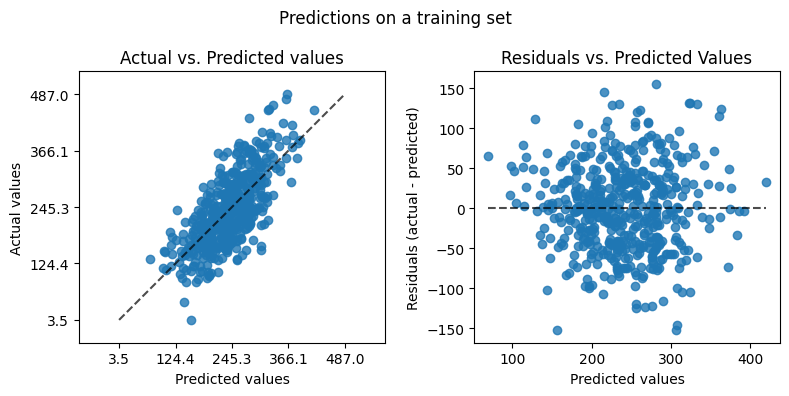

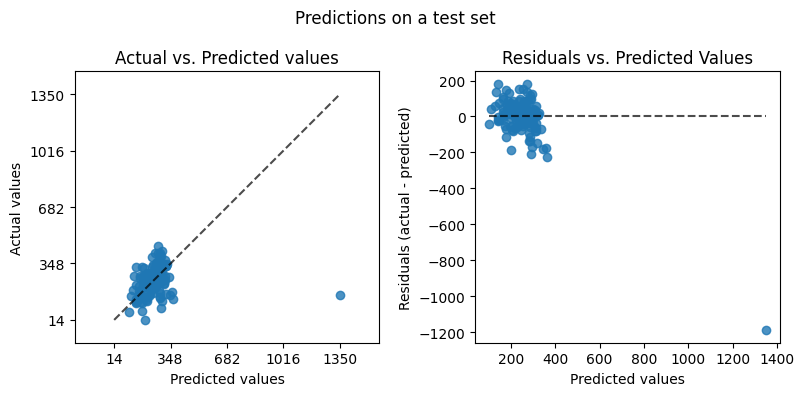

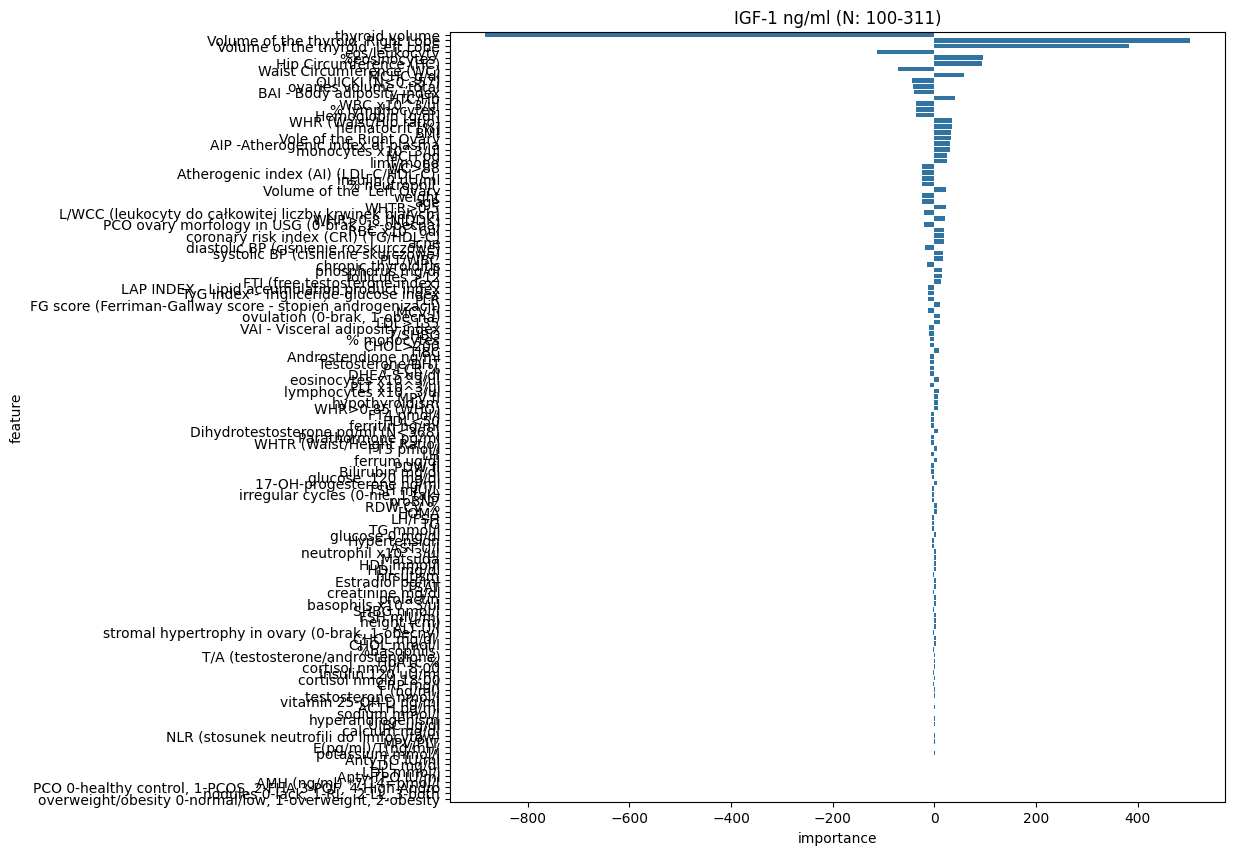

model  data_set        mse     mae     rmse     r2
0  LinearRegression()  training   2864.264  42.746   53.519  0.516
1  LinearRegression()      test  17644.244  70.916  132.832 -1.607

In [76]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr = train_model(lr_model, IGF, X_train_igf, y_train_igf, X_test_igf, y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

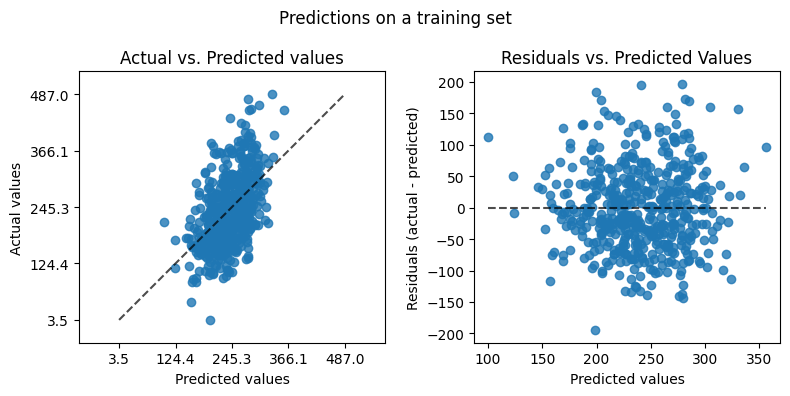

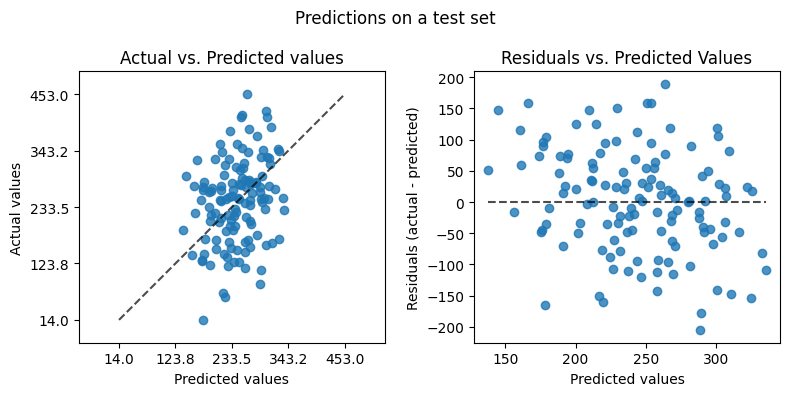

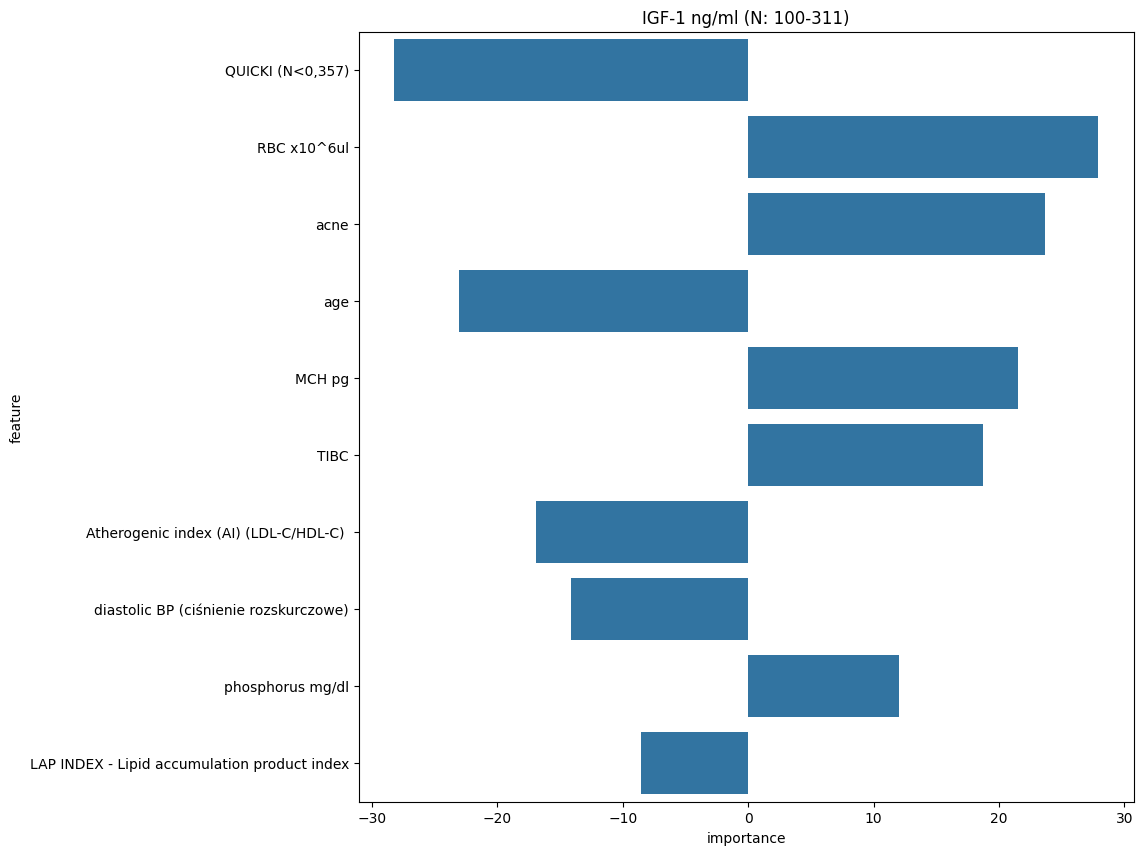

model  data_set       mse     mae    rmse     r2
0  LinearRegression()  training  4387.075  53.099  66.235  0.259
1  LinearRegression()      test  6825.282  66.568  82.615 -0.008

In [79]:
lr_model = LinearRegression()

vit_d_model_scores_df, feature_importnces_lr = train_model(lr_model, IGF, X_train_igf[intersection_all_sets], y_train_igf, X_test_igf[intersection_all_sets], y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

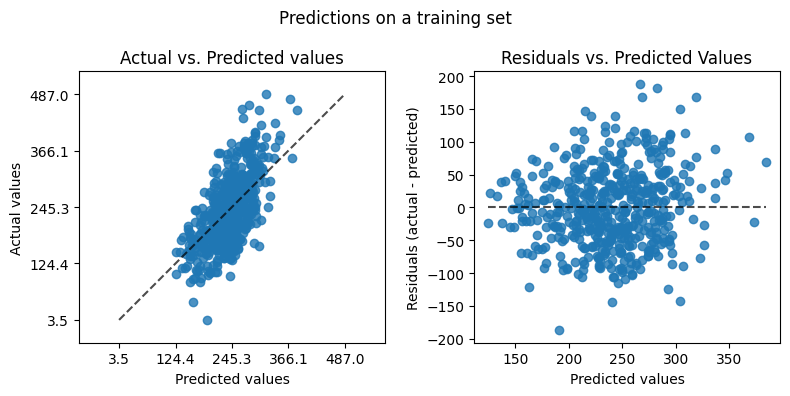

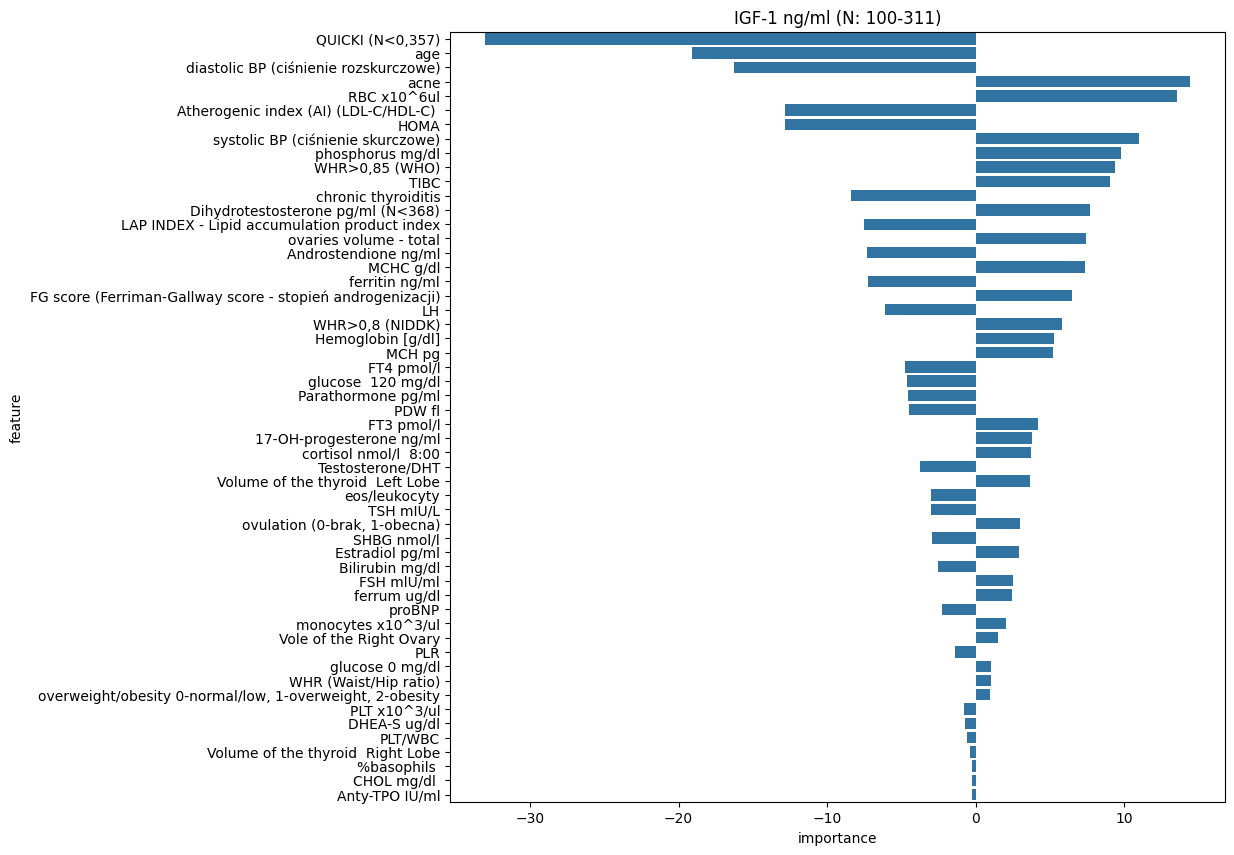

model  data_set       mse     mae    rmse     r2
0  Lasso(alpha=1)  training  3441.745  47.517  58.666  0.419
1  Lasso(alpha=1)      test  6718.857  62.722  81.969  0.007

In [69]:
lasso_model = Lasso(alpha=1)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, IGF, X_train_igf[union_all_sets], y_train_igf, X_test_igf[union_all_sets], y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

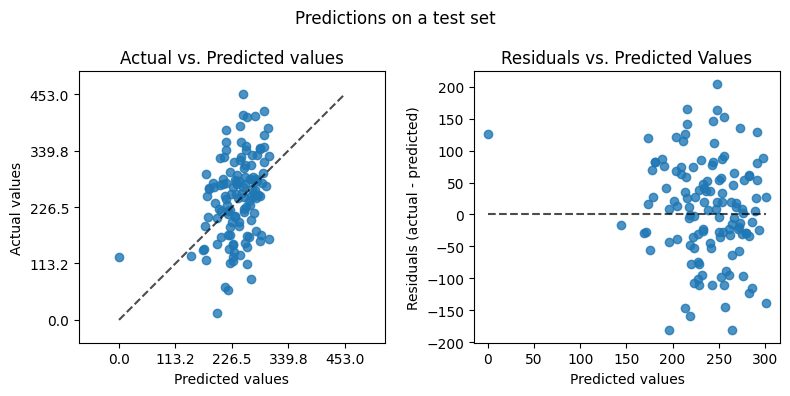

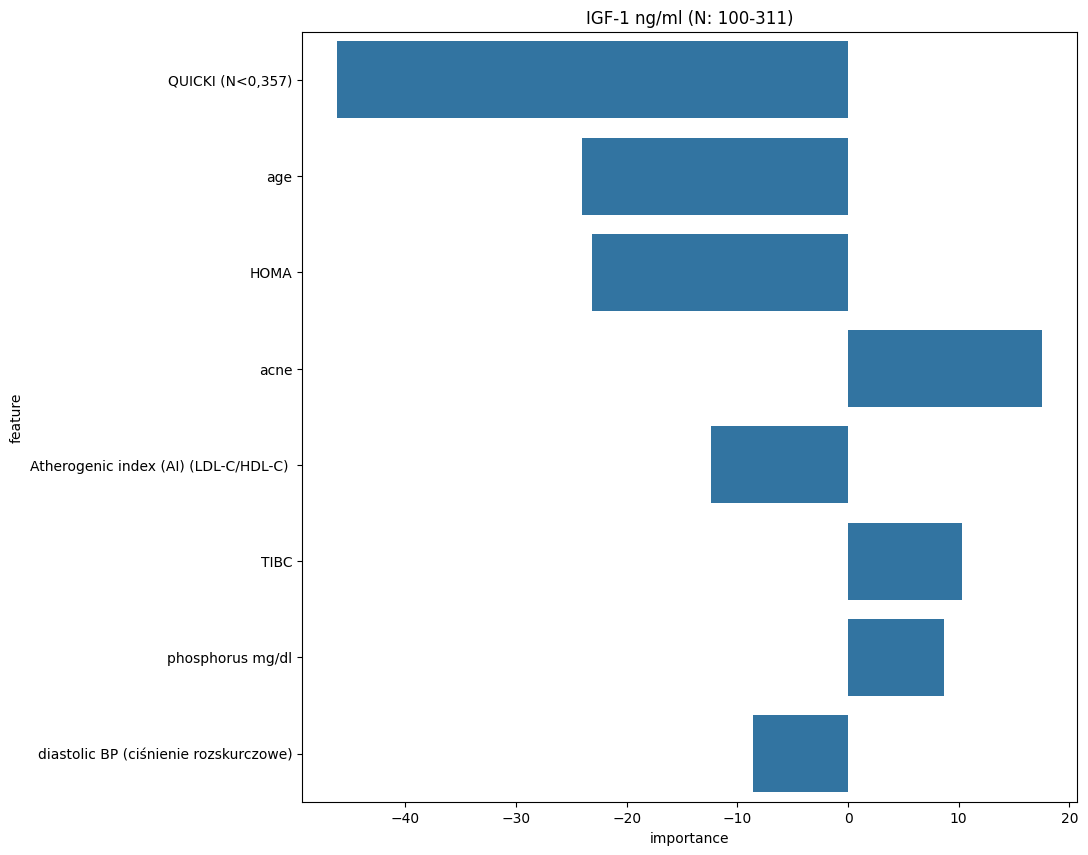

model  data_set       mse     mae    rmse     r2
0  Lasso(alpha=1)  training  4606.391  54.457  67.870  0.222
1  Lasso(alpha=1)      test  6164.515  62.860  78.514  0.089

In [70]:
lasso_model = Lasso(alpha=1)

vit_d_model_scores_df, feature_importnces_lasso = train_model(lasso_model, IGF, X_train_igf[intersection_all_sets], y_train_igf, X_test_igf[intersection_all_sets], y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

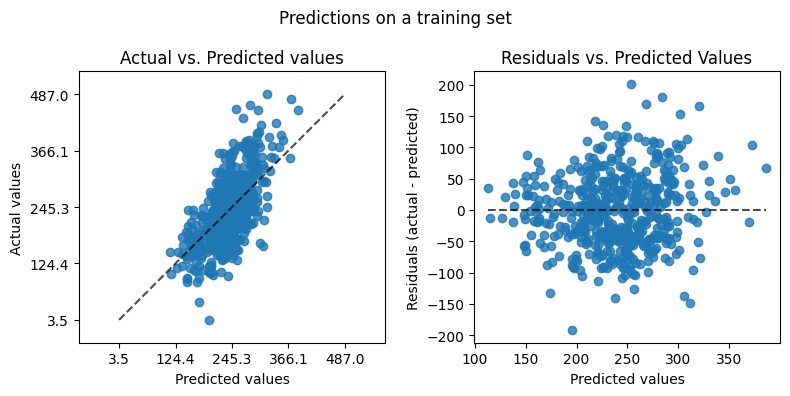

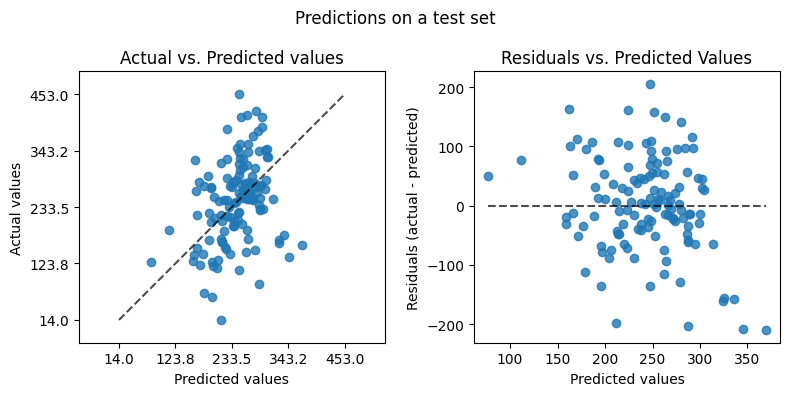

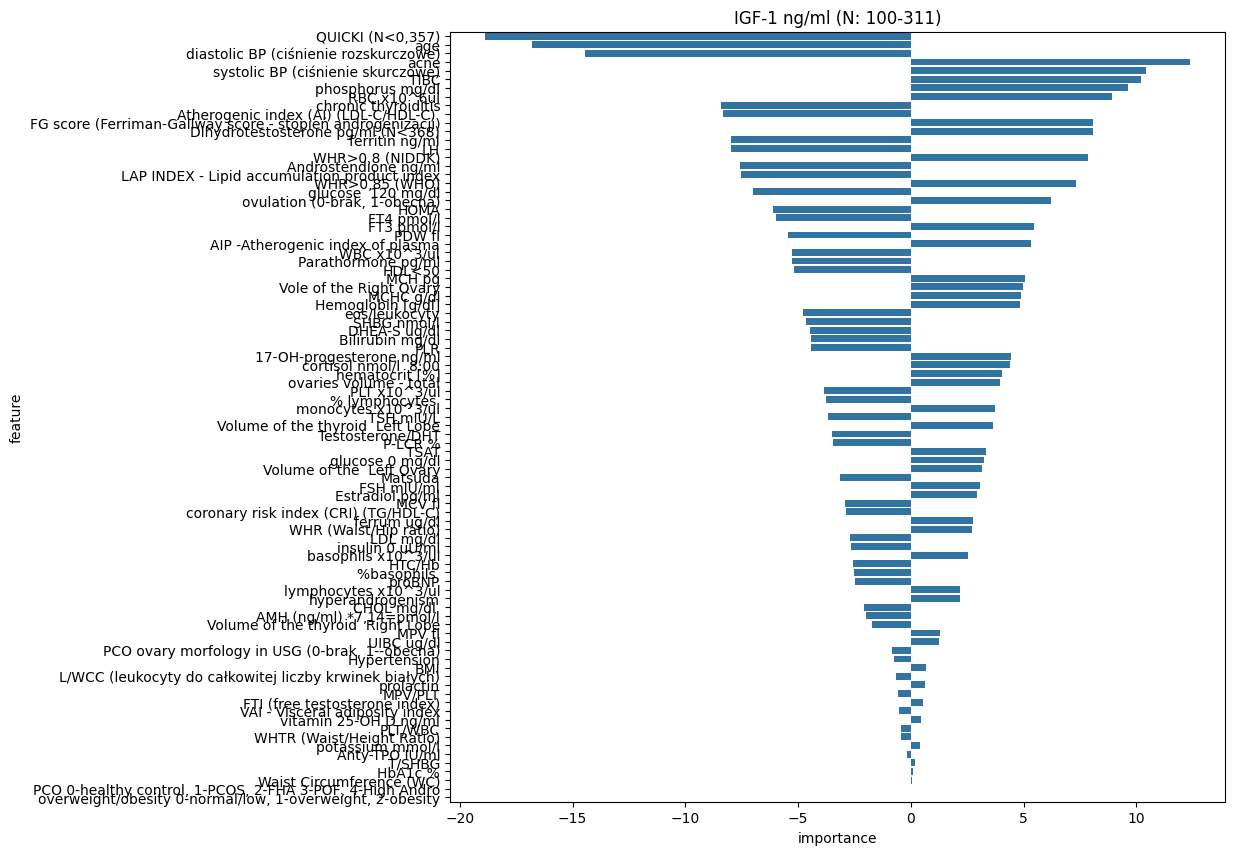

model  data_set       mse     mae    rmse     r2
0  Ridge(alpha=50)  training  3387.853  46.920  58.205  0.428
1  Ridge(alpha=50)      test  6520.451  62.431  80.749  0.037

In [71]:
ridge_model = Ridge(alpha=50)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, IGF, X_train_igf[union_all_sets], y_train_igf, X_test_igf[union_all_sets], y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df

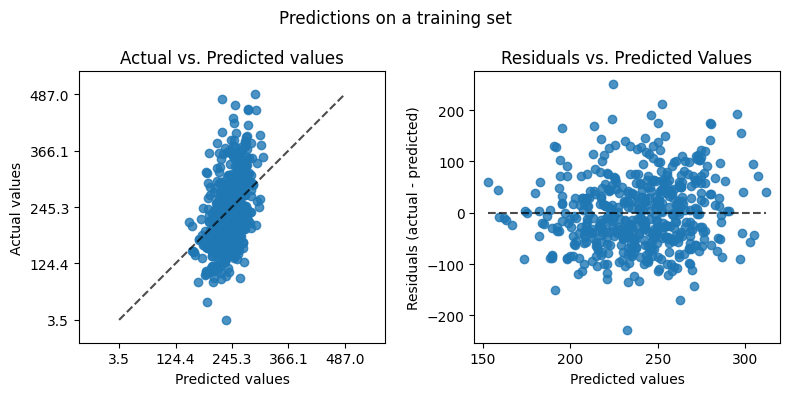

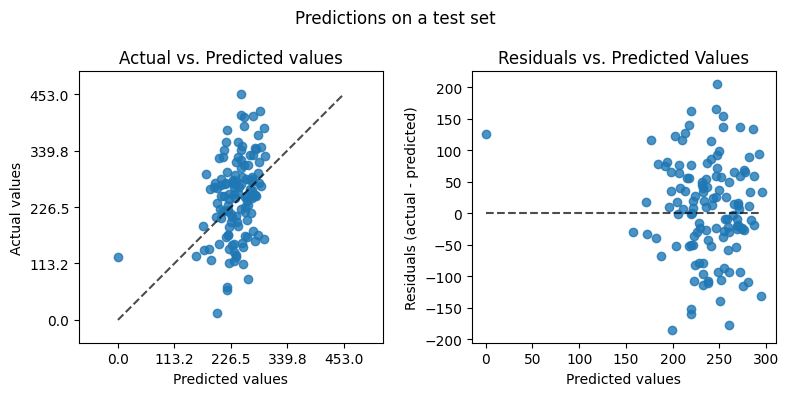

model  data_set       mse     mae    rmse     r2
0  Ridge(alpha=50)  training  4704.495  55.129  68.589  0.205
1  Ridge(alpha=50)      test  6141.732  62.840  78.369  0.093

In [72]:
ridge_model = Ridge(alpha=50)

vit_d_model_scores_df, feature_importnces_ridge = train_model(ridge_model, IGF, X_train_igf[intersection_all_sets], y_train_igf, X_test_igf[intersection_all_sets], y_test_igf, continuous_preprocessor, categorical_preprocessor, get_feature_importance_lasso)
vit_d_model_scores_df